In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import kagglehub
import shutil
import os


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import and move the datasets

In [2]:

path = kagglehub.dataset_download("gpreda/chinese-mnist")
print("Path to dataset files:", path)


for file_name in os.listdir(path):
    full_file_name = os.path.join(path, file_name)
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, './')

Path to dataset files: C:\Users\mathi\.cache\kagglehub\datasets\gpreda\chinese-mnist\versions\7


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Splitting the data in a train dataset (80%) and a test dataset (20%)

In [29]:
dataset = pd.read_csv('chinese_mnist.csv')

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [30]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=132, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=132, shuffle=True, num_workers=2)

In [39]:
image, label = dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

KeyError: 0

In [36]:
image.size()

torch.Size([1, 3, 32, 32])

In [31]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())  # Returns current device index
print(torch.cuda.device_count())    # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


True
0
1
NVIDIA GeForce GTX 1060 3GB


In [18]:
class_names = ['0'  , '1'  , '2'  , '3'  , '4'  , '5'  , '6'  , '7'  , '8'  , '9'  , '10' , '100', '1000', '10000', '100000000']

In [33]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Output: (64, 32, 32)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: (128, 32, 32)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Output: (256, 32, 32)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Output: (512, 32, 32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (512, 16, 16)

        # Dropout layers
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Conv4 -> BatchNorm -> ReLU -> Pool
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.dropout(F.relu(self.fc1(x)))  # Fully connected layer 1 with dropout
        x = self.dropout(F.relu(self.fc2(x)))  # Fully connected layer 2 with dropout
        x = self.fc3(x)  # Fully connected layer 3
        return x


In [34]:
net = NeuralNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [35]:
epochNB = 20
losses = []

for epoch in range(epochNB) :
    print("Training epoch : " + str(epoch))

    running_loss = 0.0

    for i, data in enumerate(train_loader) :
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochNB}, Loss: {epoch_loss:.4f}")
    
# Plot the training loss
plt.plot(range(1, epochNB + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Training epoch : 0


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 2371

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\_utils\fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\frame.py", line 4102, in __getitem__
    indexer = self.columns.get_loc(key)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 2371


In [25]:
torch.save(net.state_dict(), 'trained_net.pth')

In [26]:
net = NeuralNet().to(device)
net.load_state_dict(torch.load('trained_net.pth'))

<All keys matched successfully>

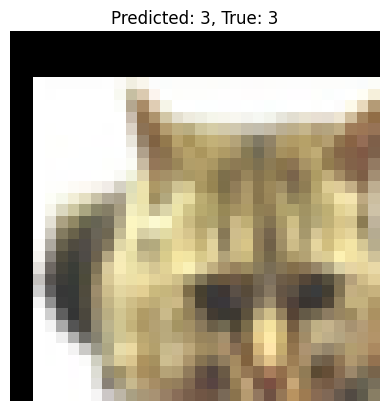

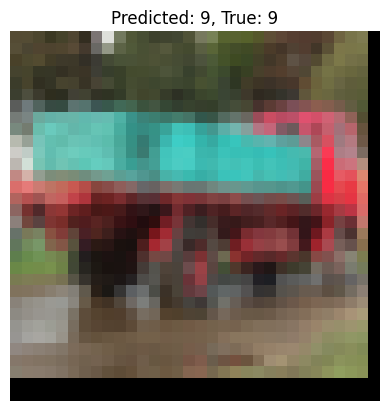

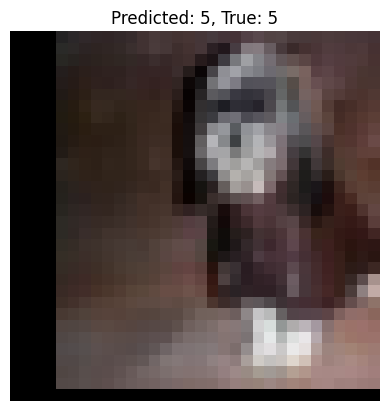

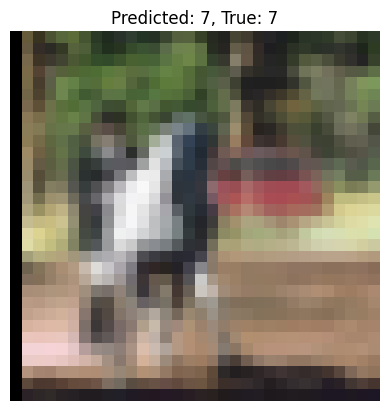

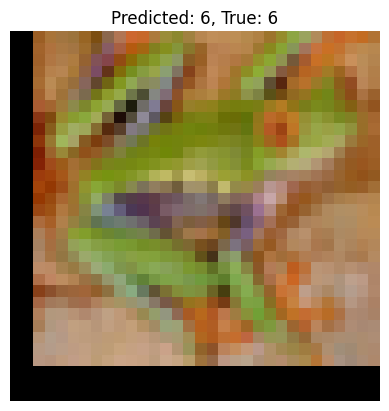

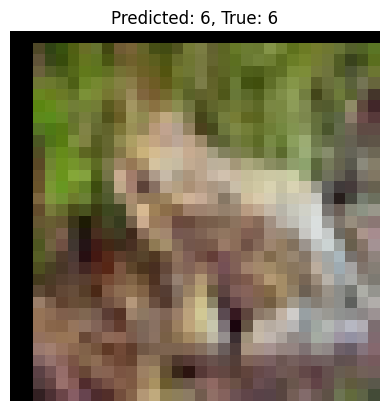

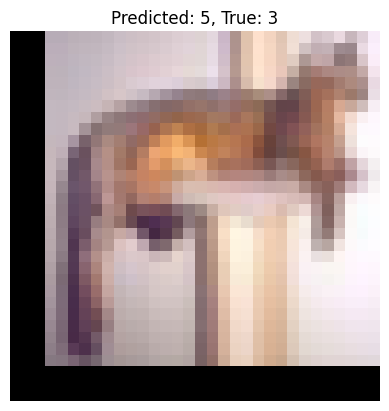

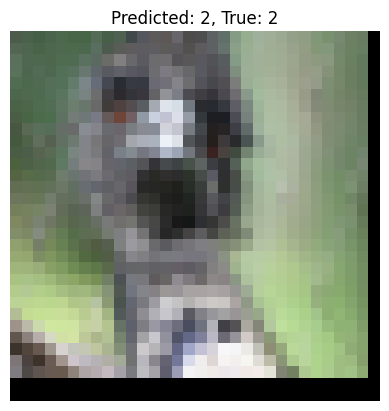

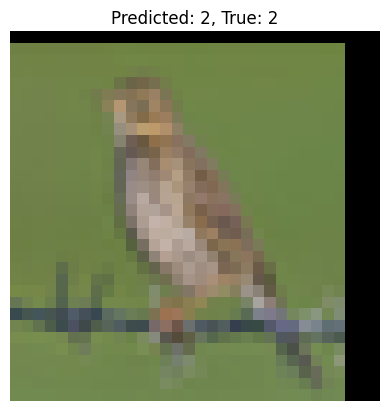

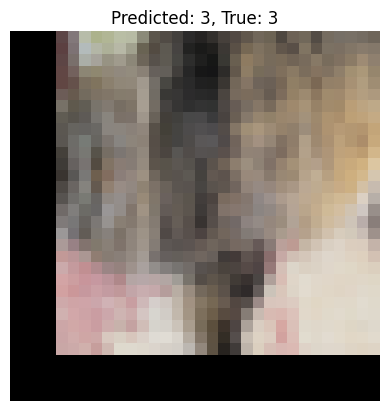

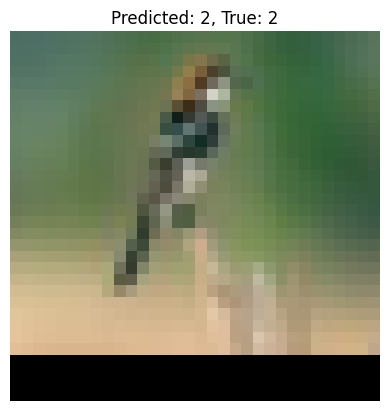

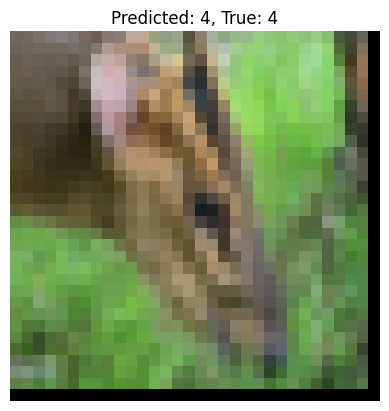

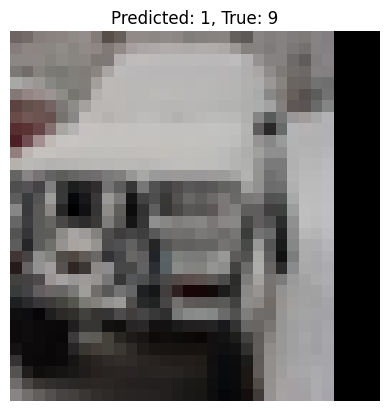

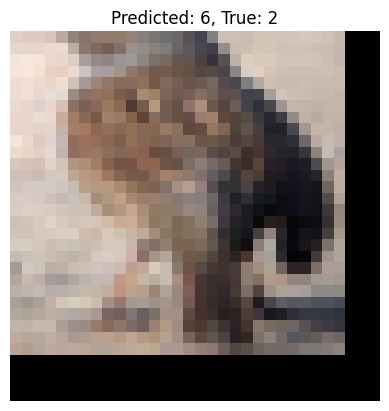

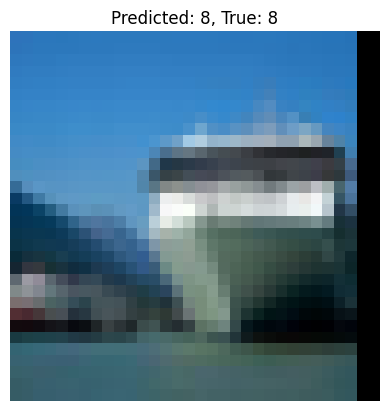

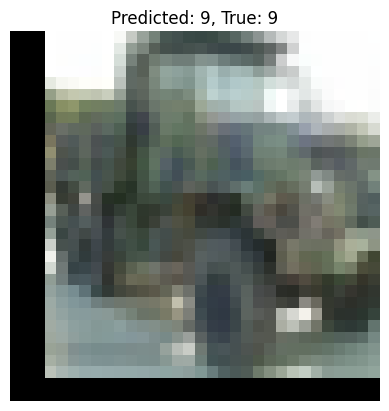

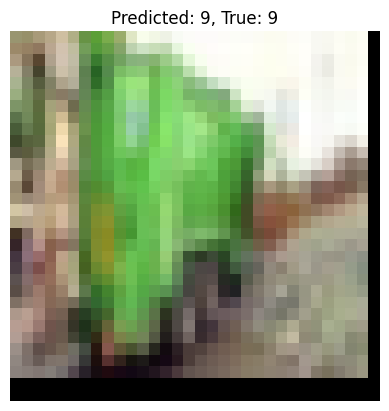

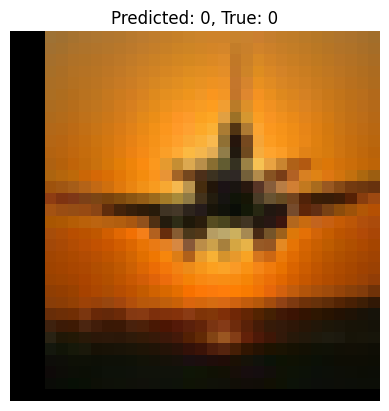

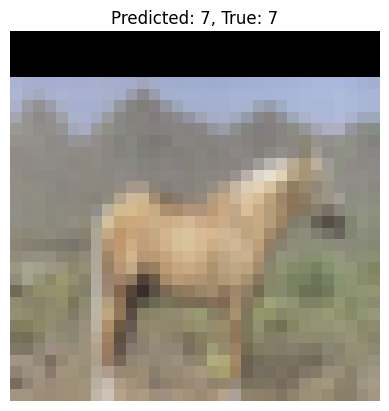

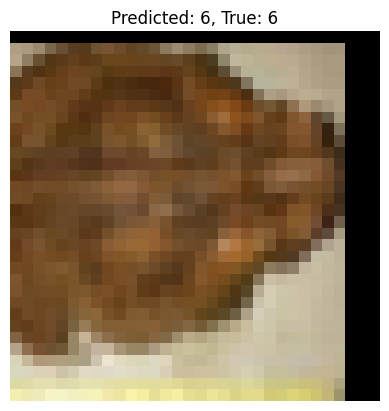

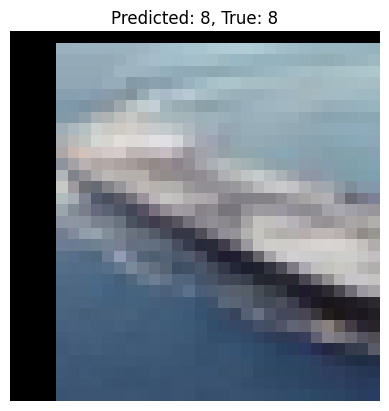

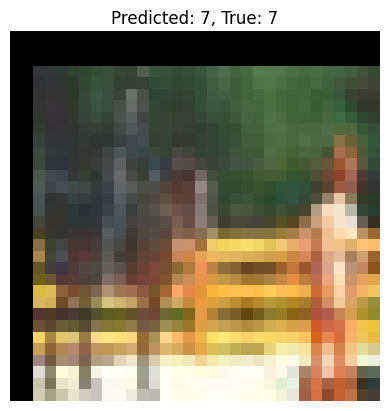

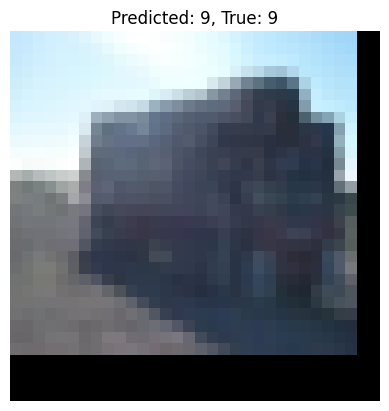

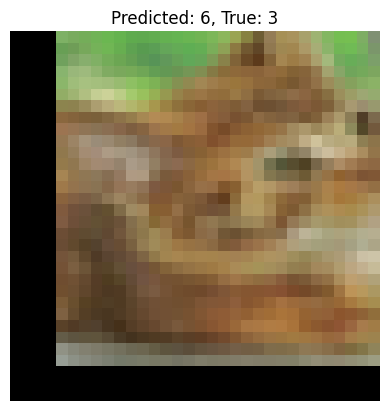

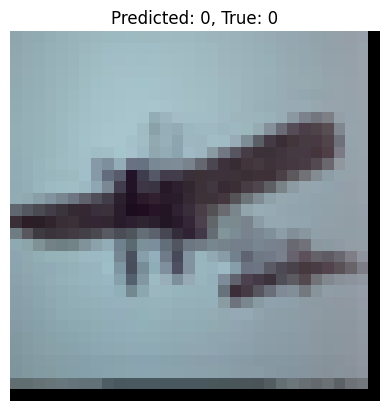

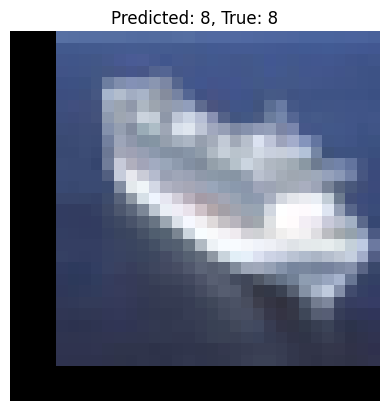

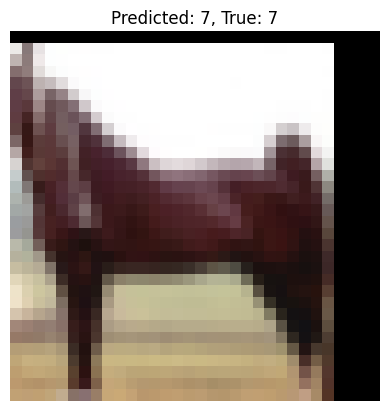

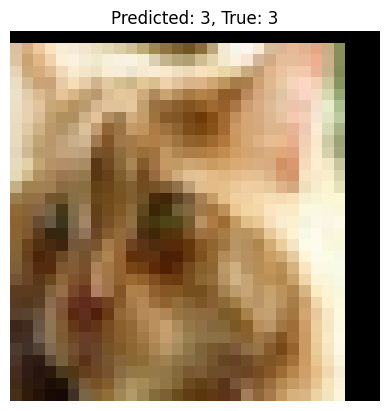

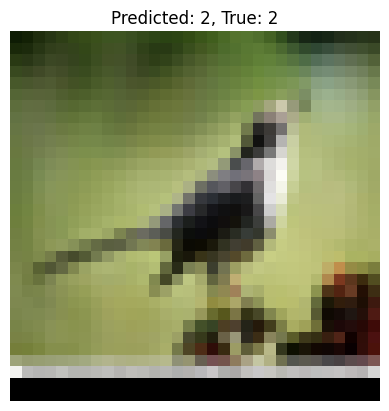

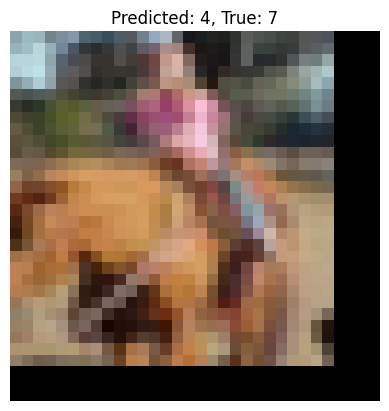

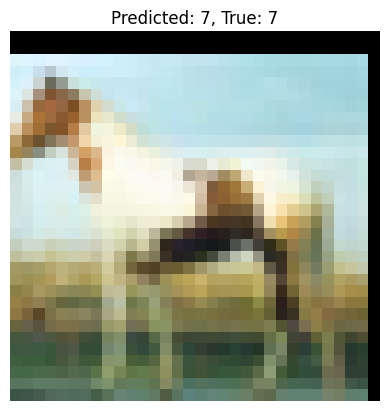

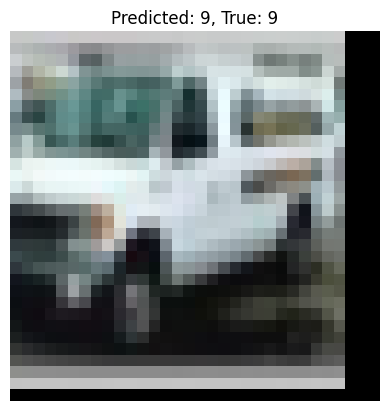

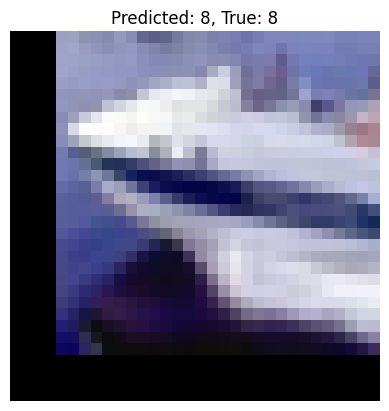

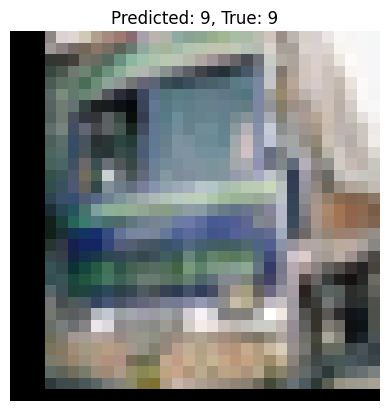

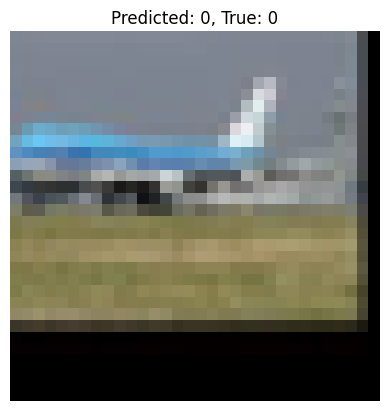

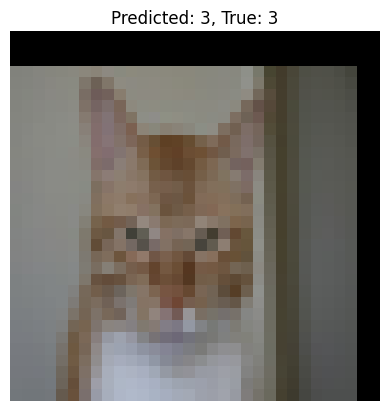

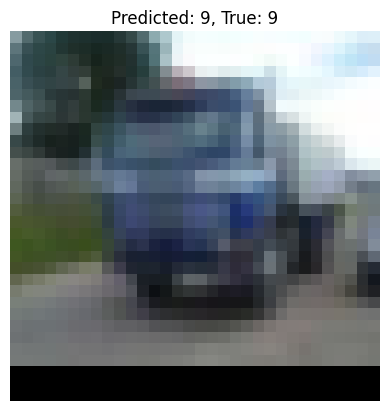

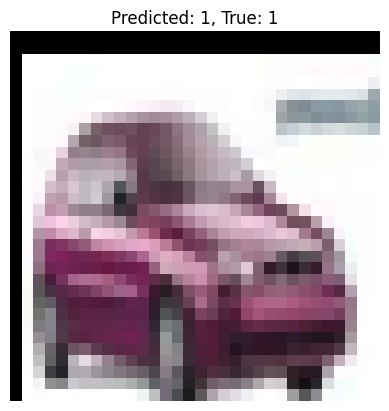

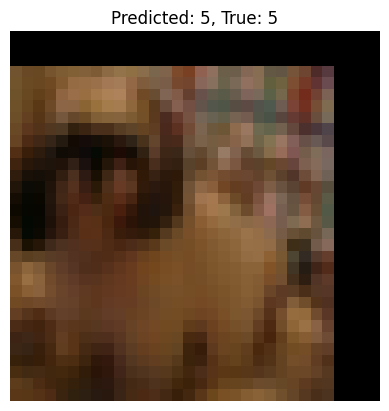

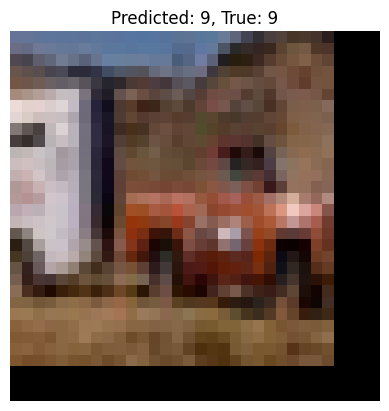

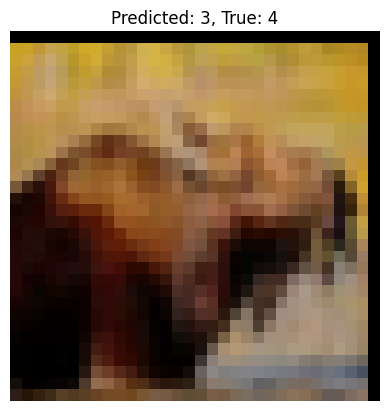

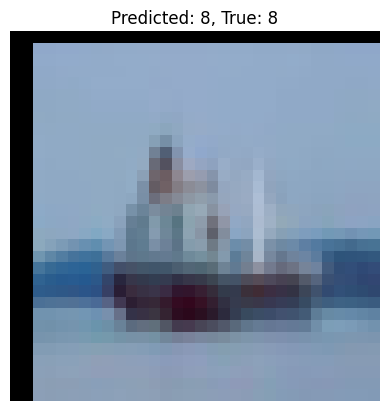

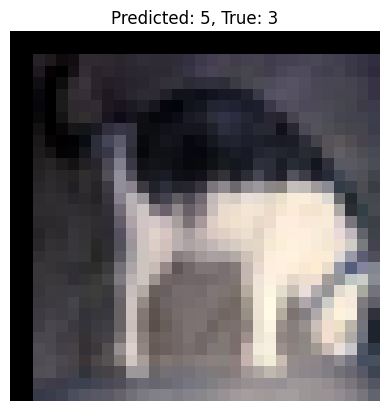

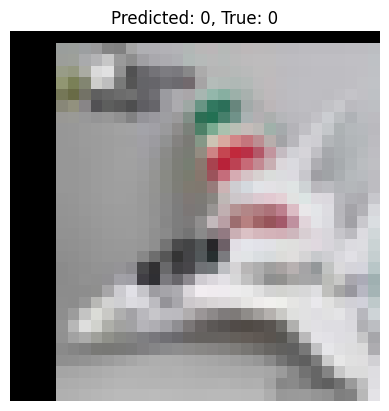

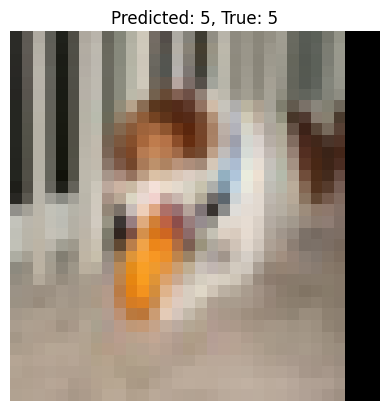

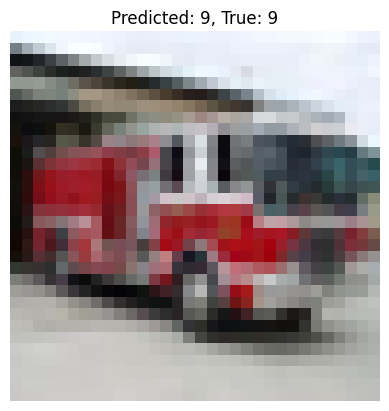

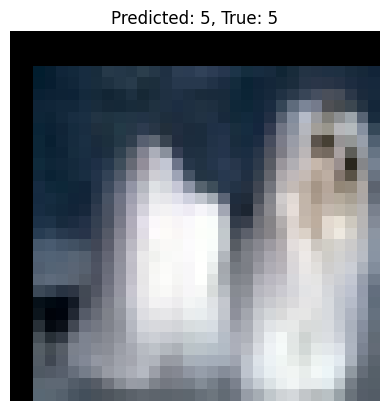

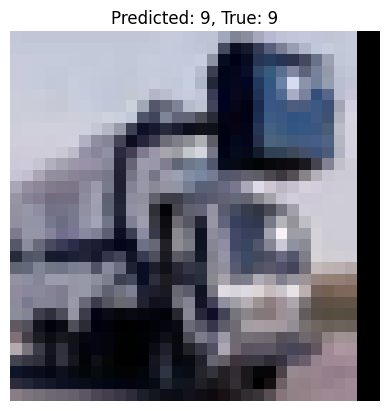

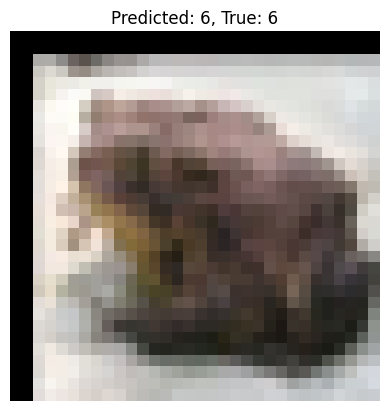

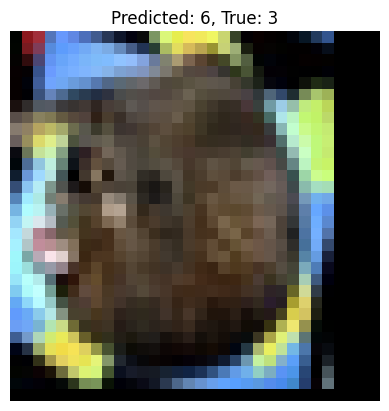

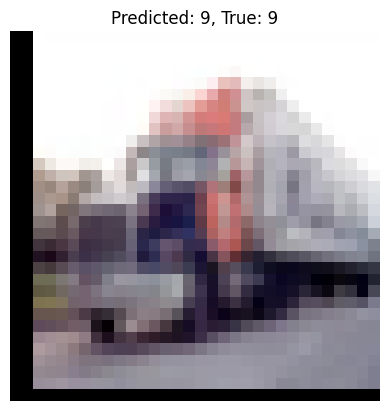

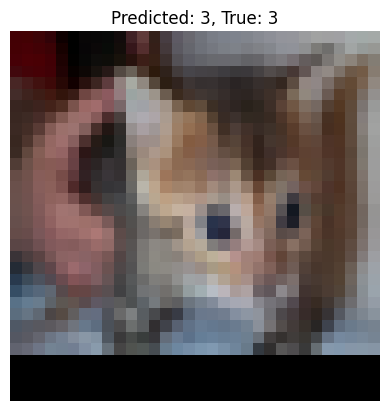

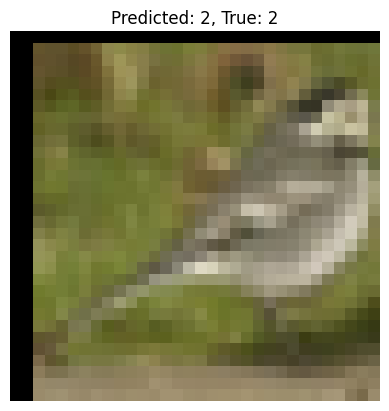

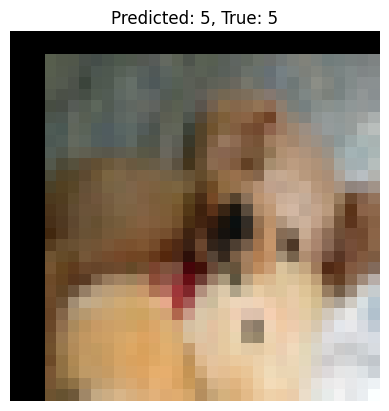

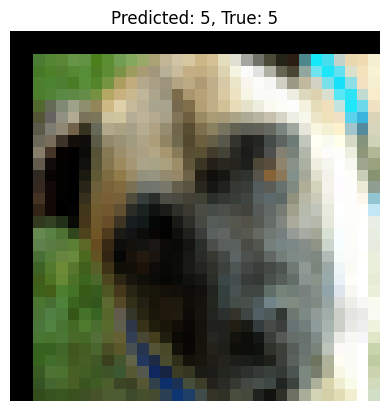

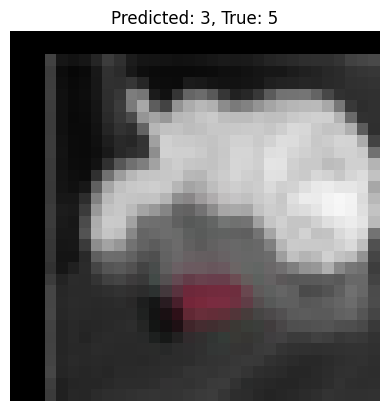

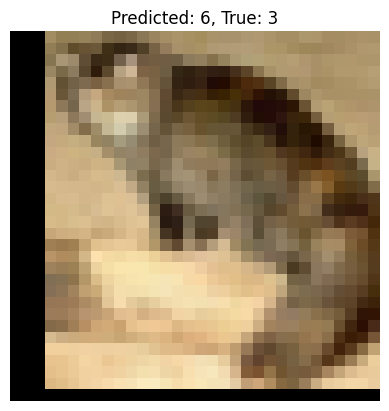

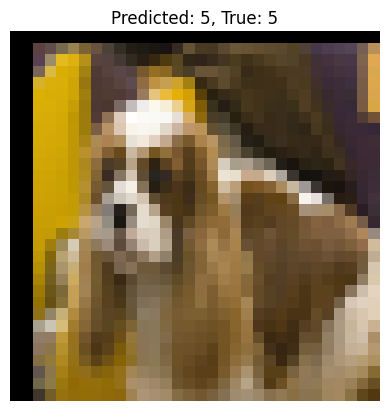

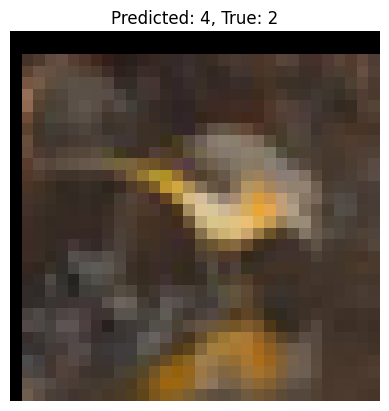

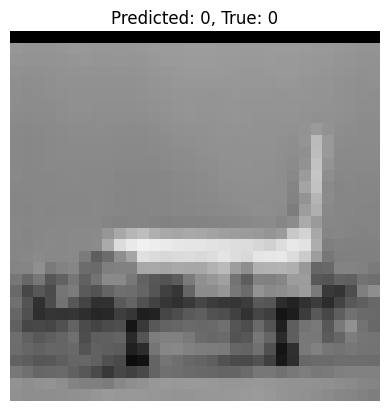

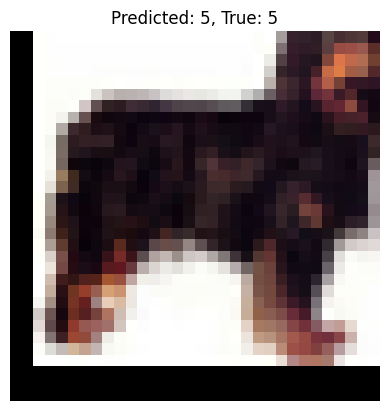

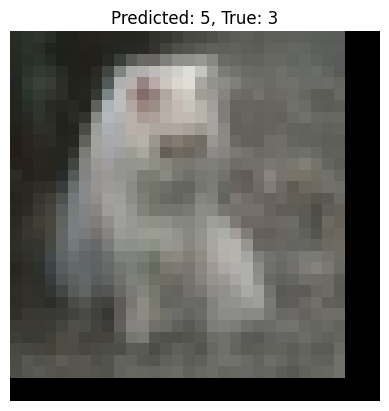

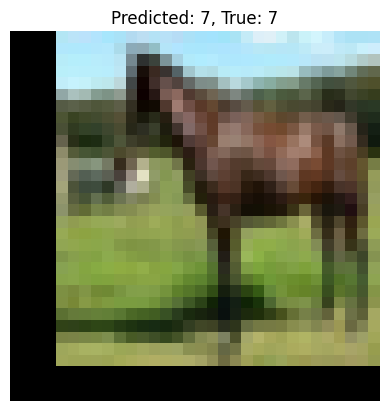

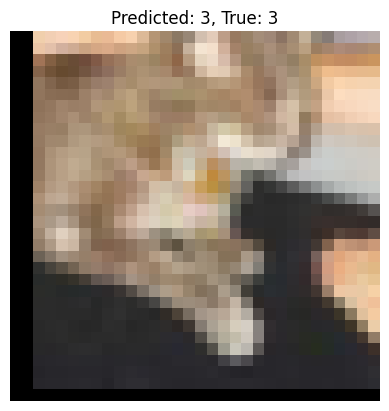

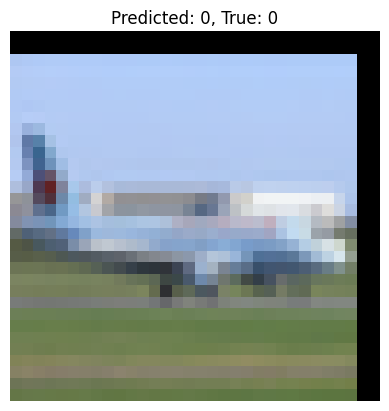

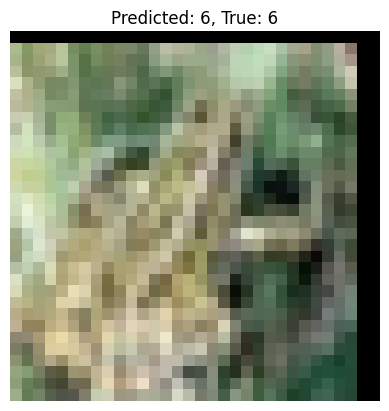

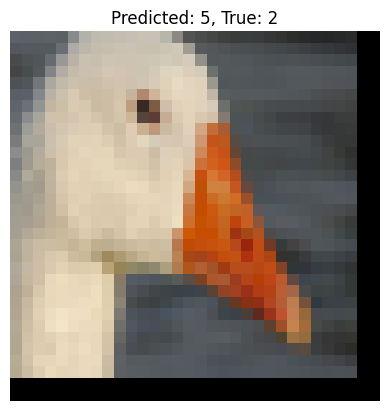

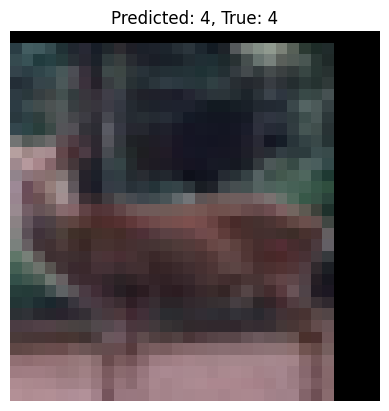

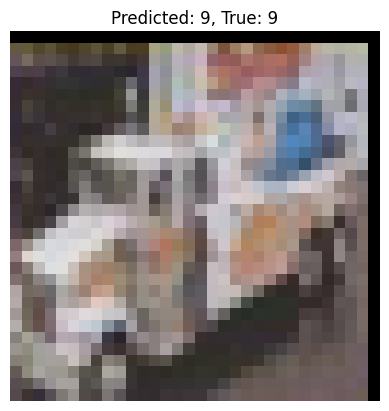

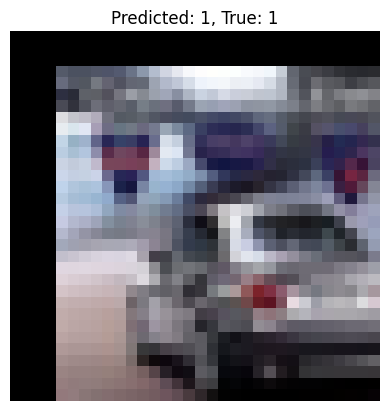

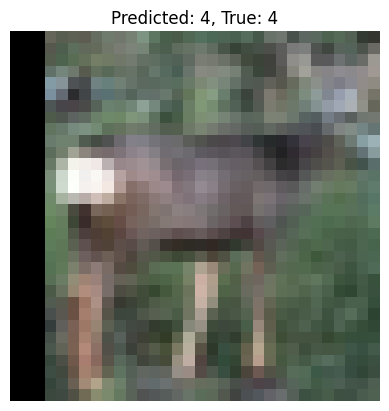

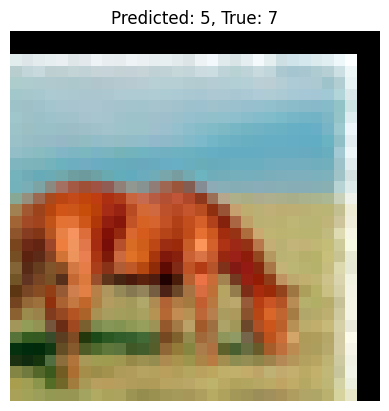

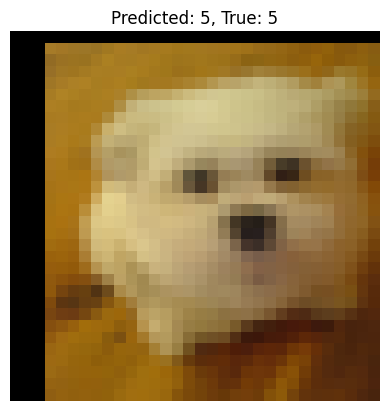

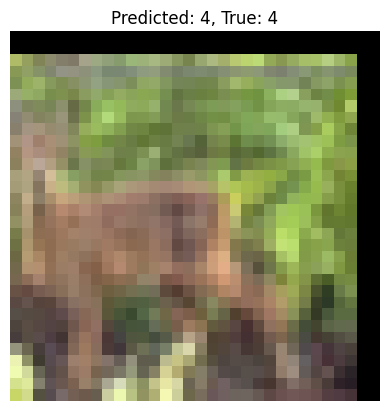

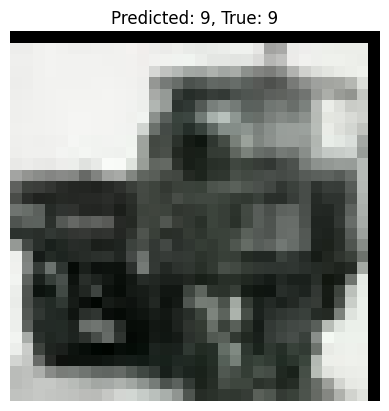

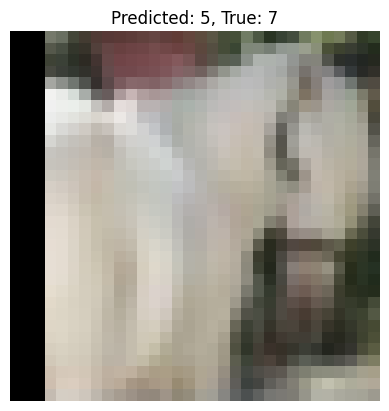

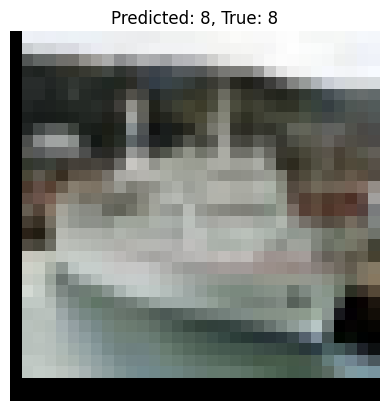

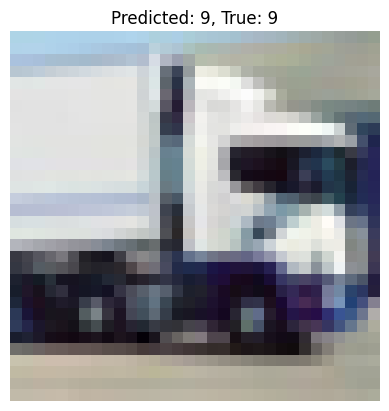

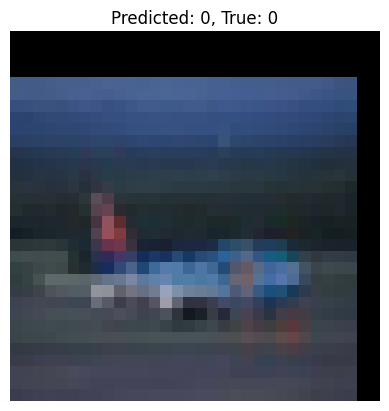

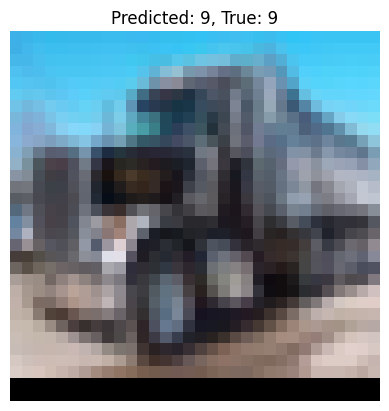

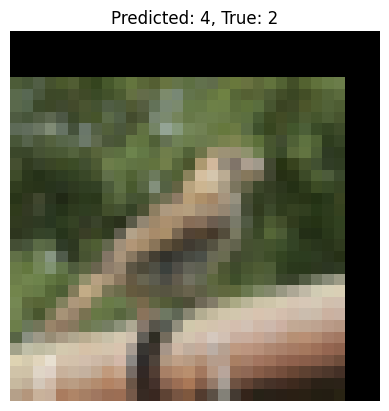

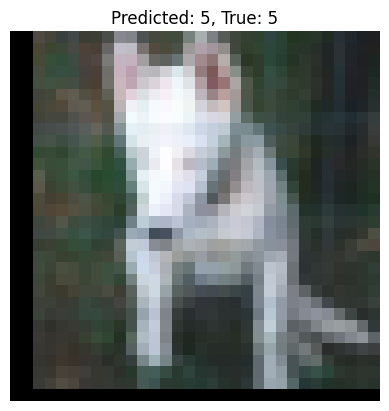

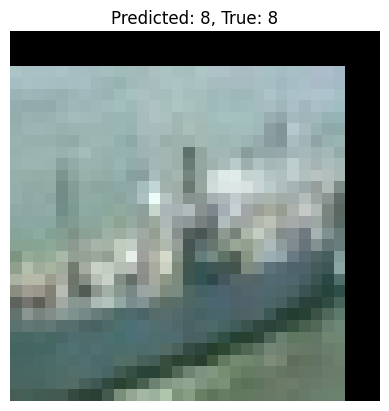

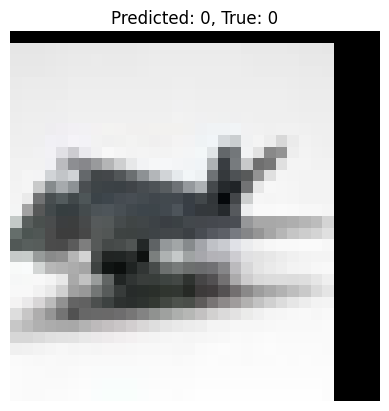

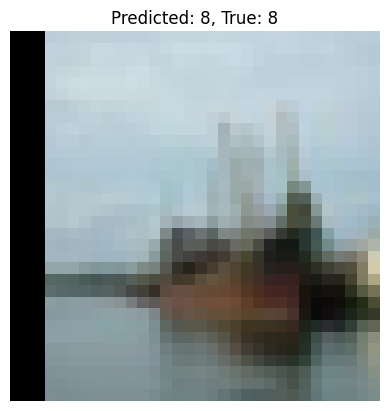

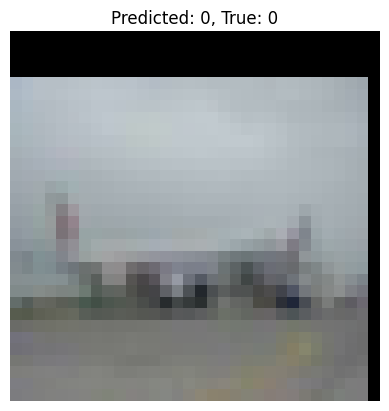

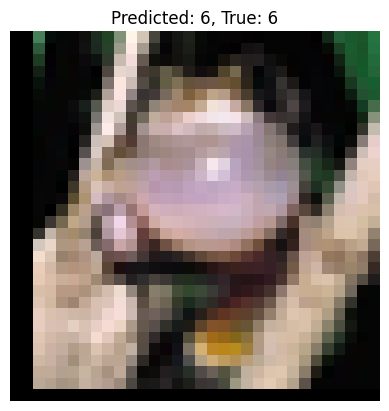

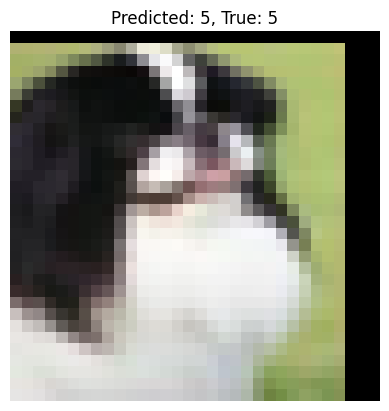

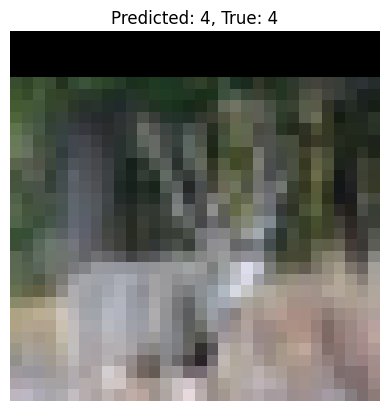

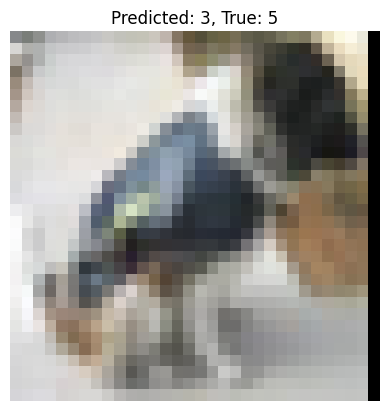

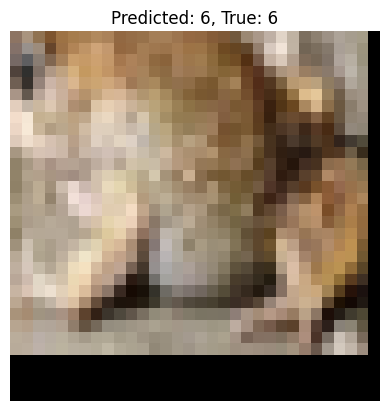

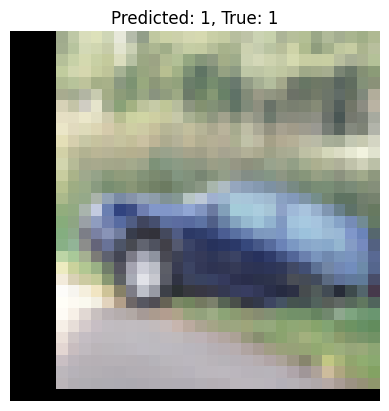

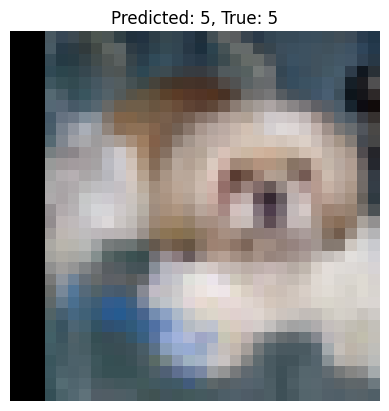

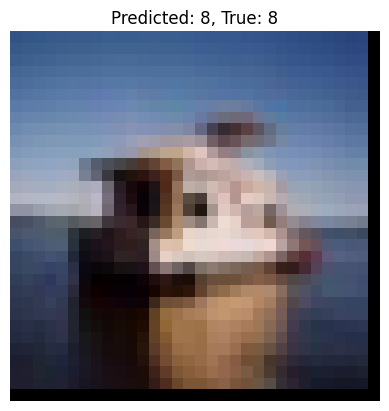

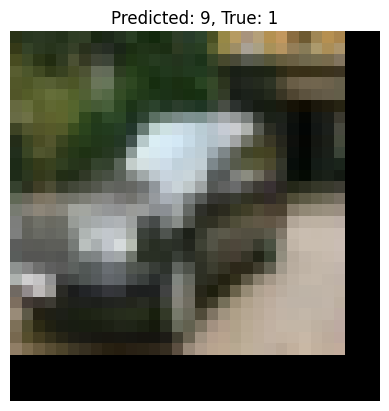

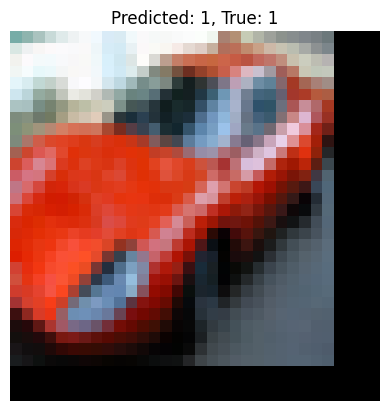

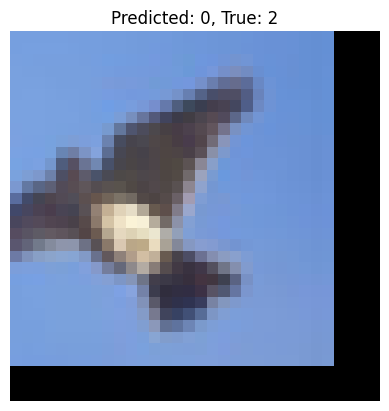

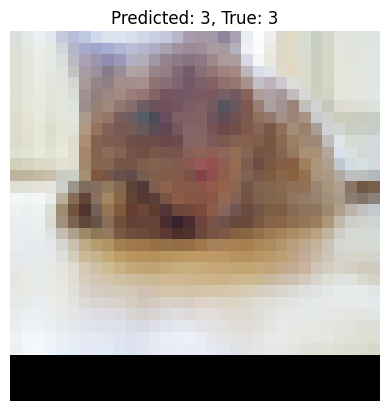

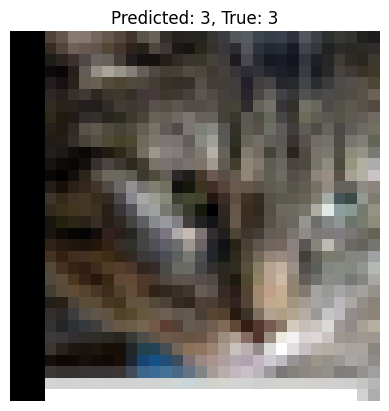

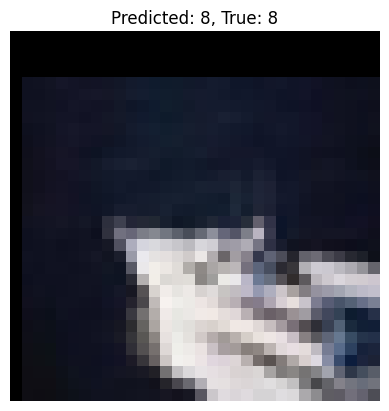

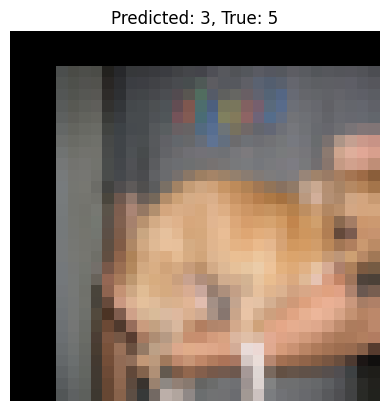

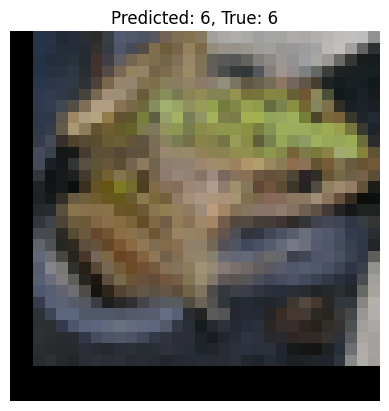

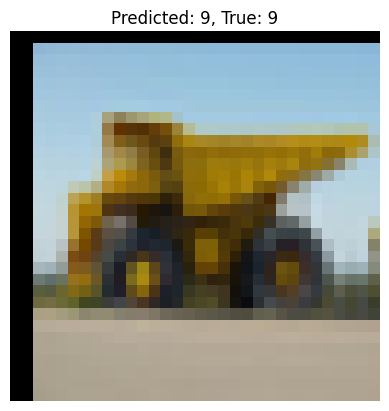

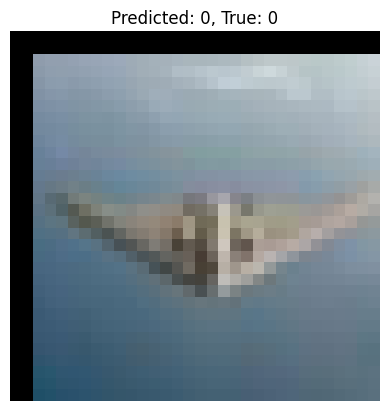

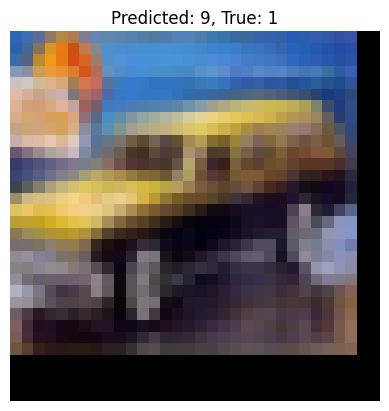

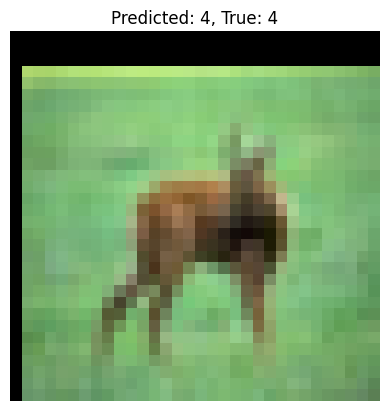

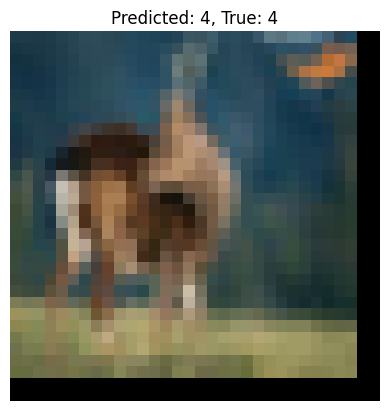

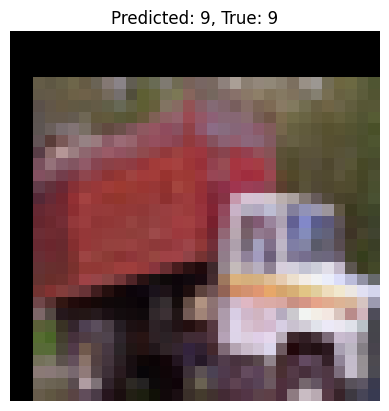

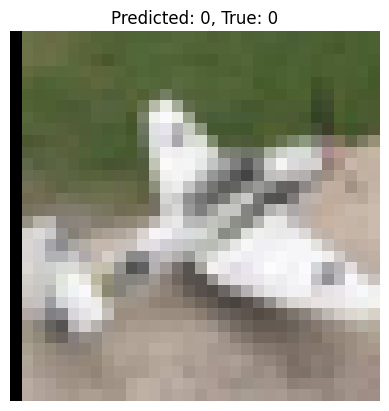

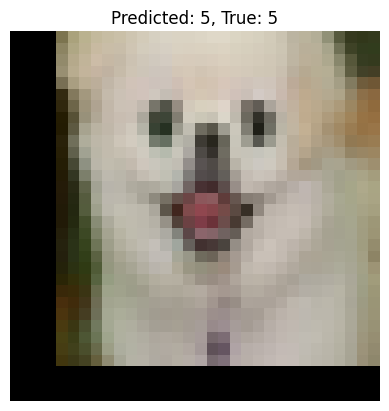

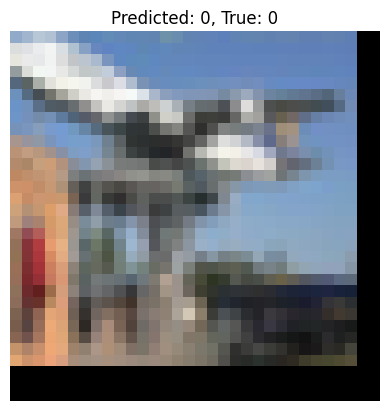

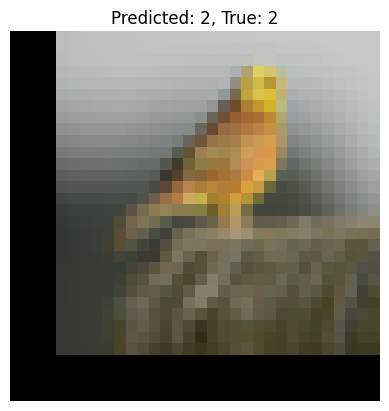

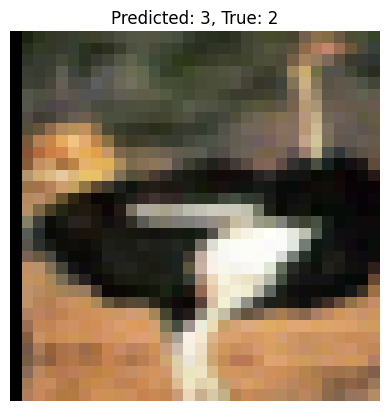

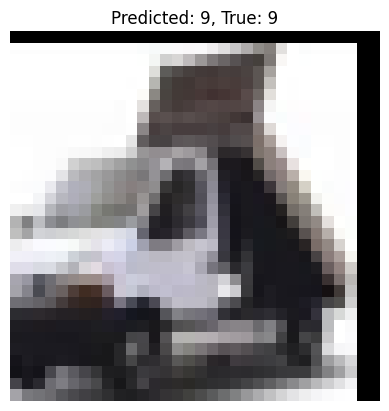

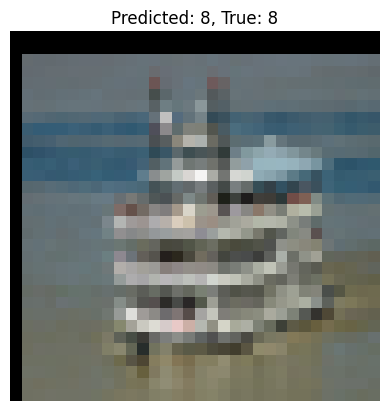

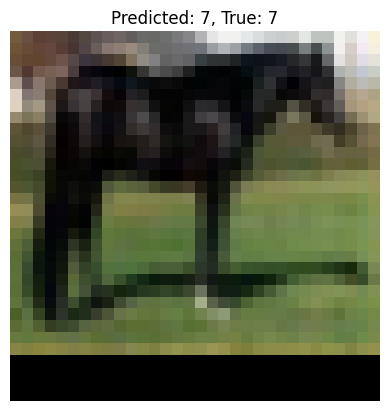

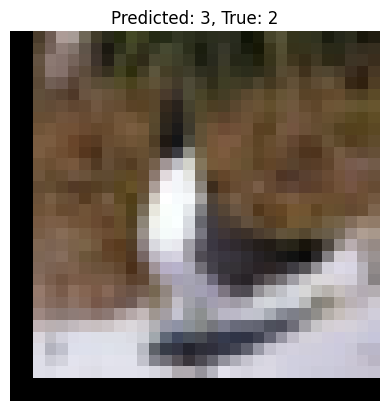

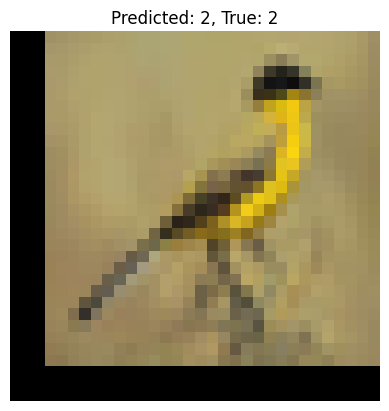

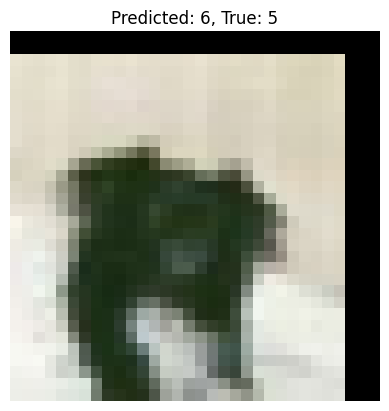

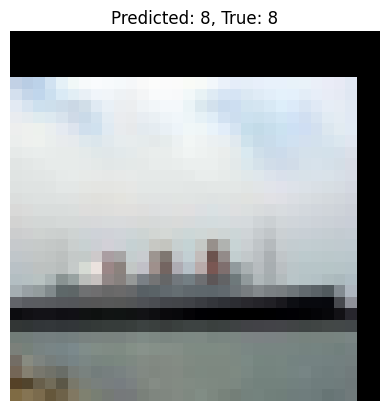

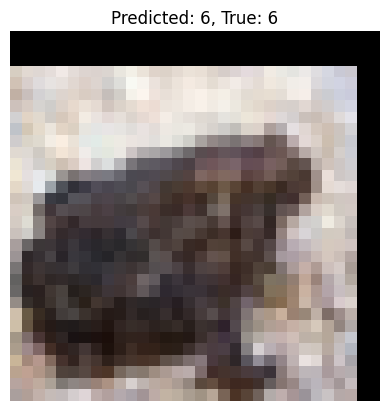

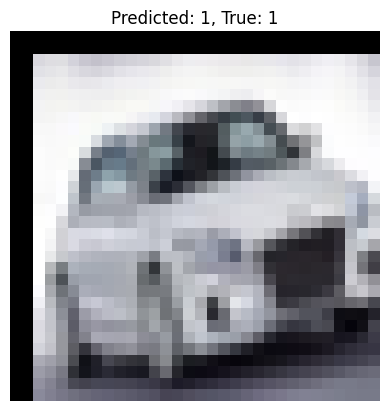

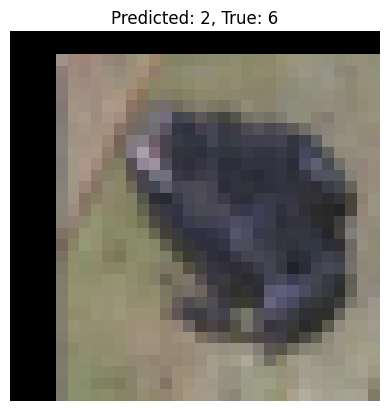

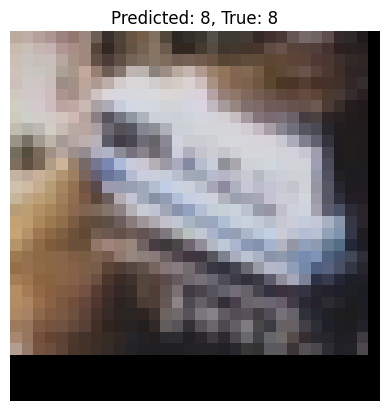

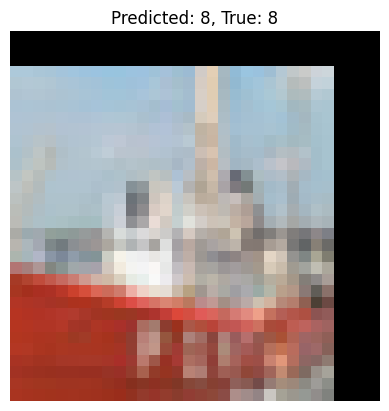

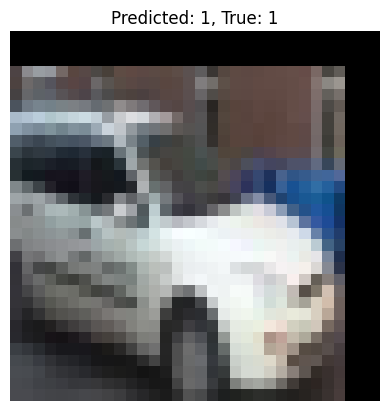

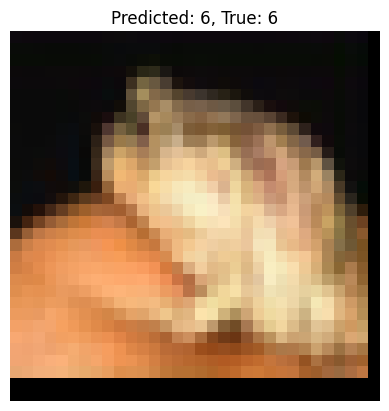

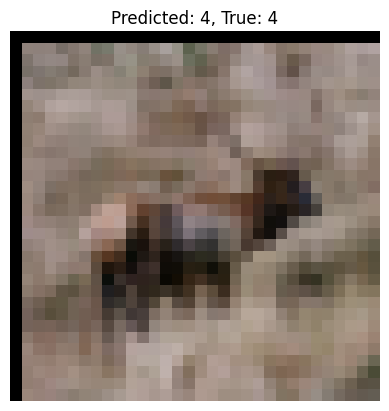

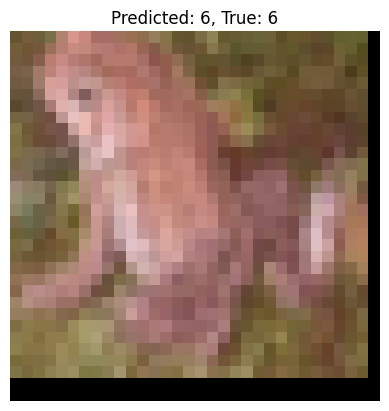

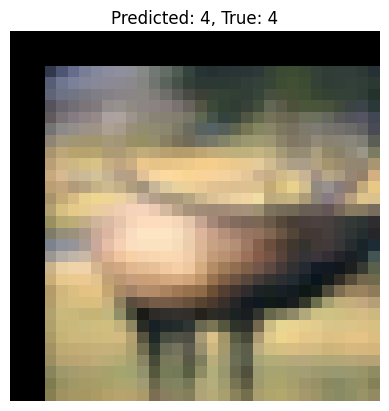

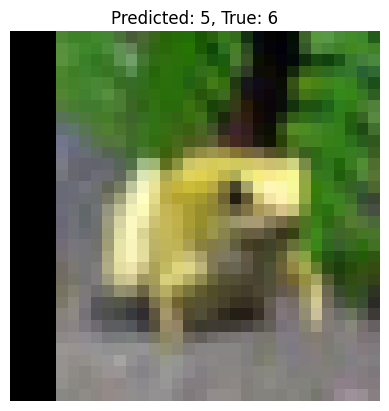

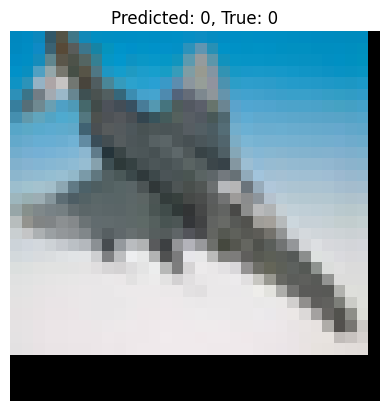

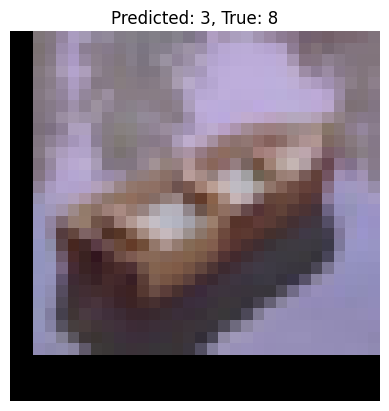

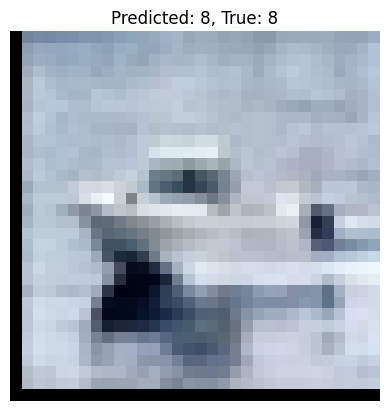

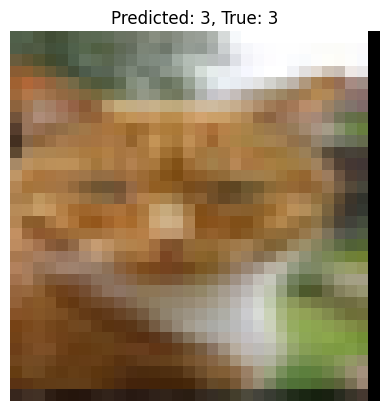

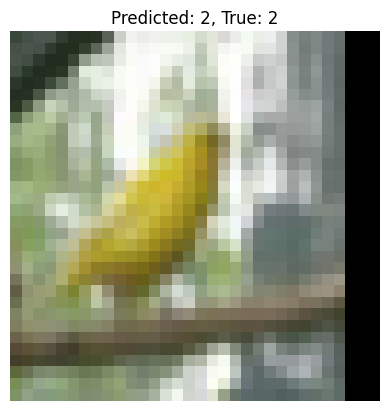

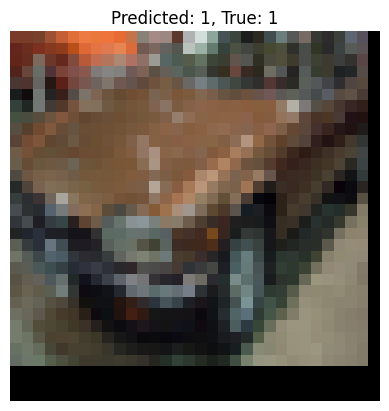

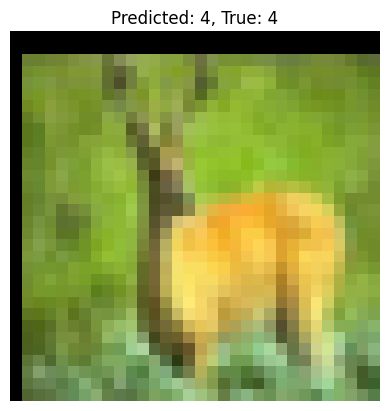

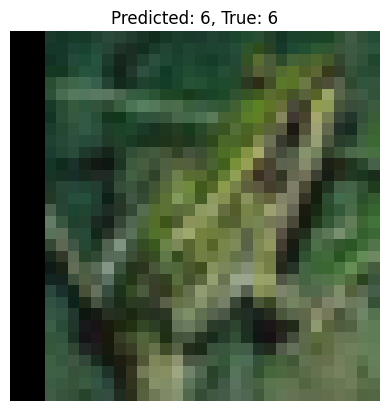

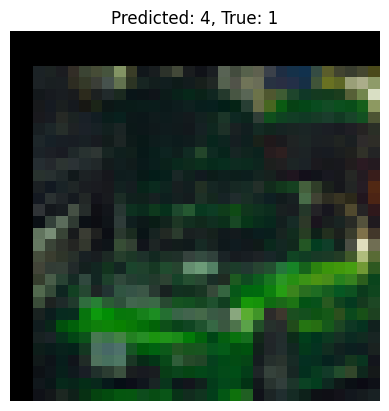

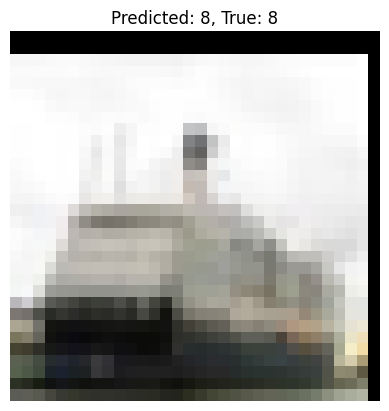

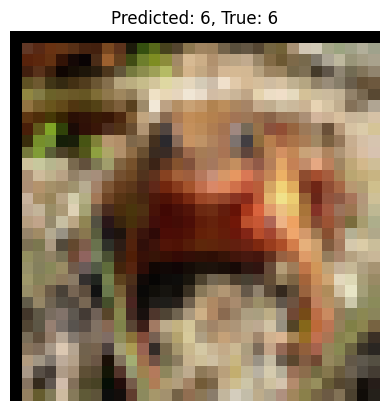

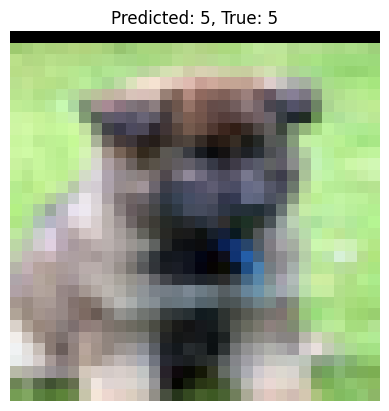

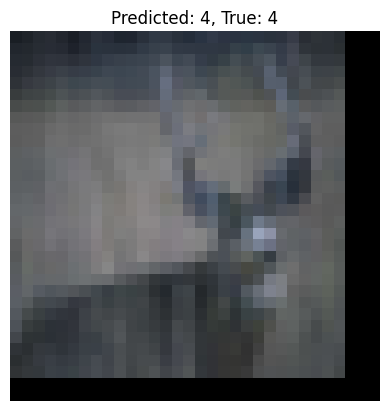

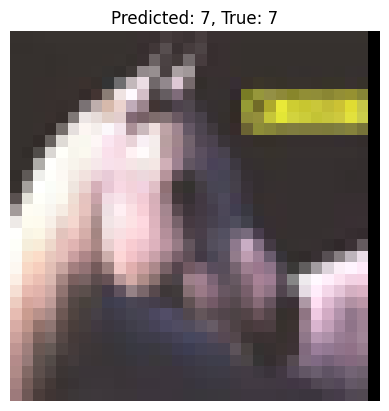

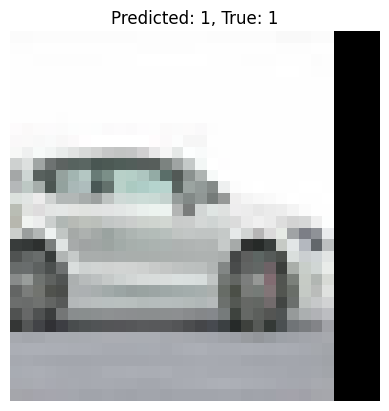

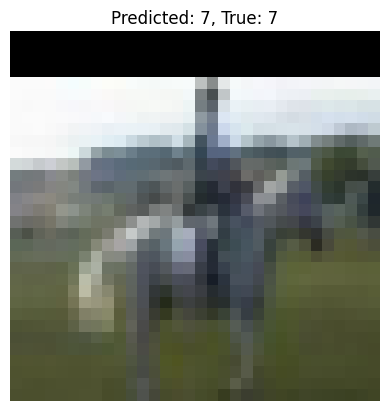

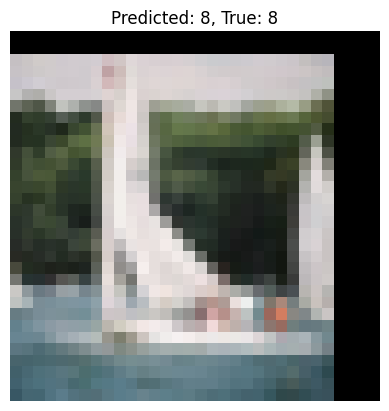

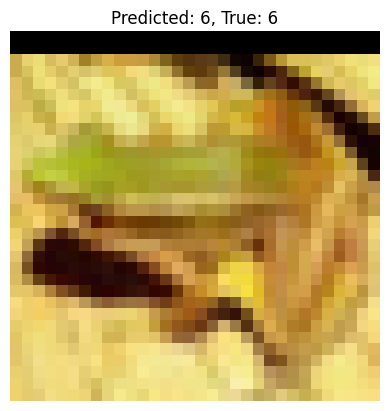

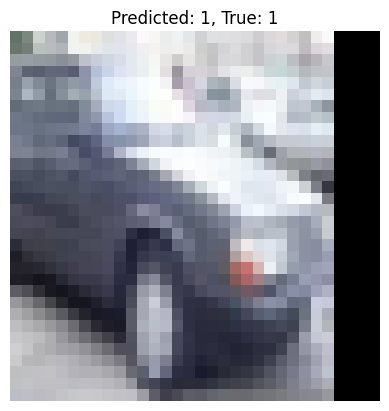

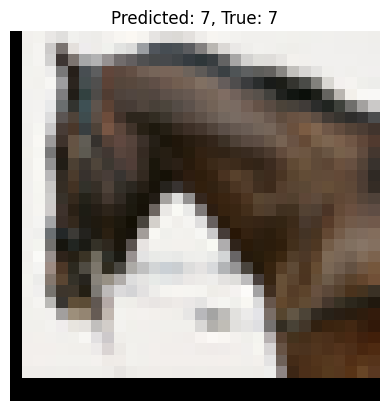

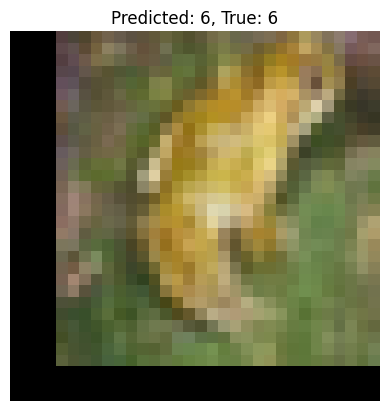

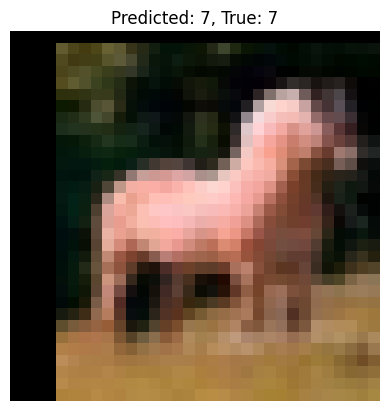

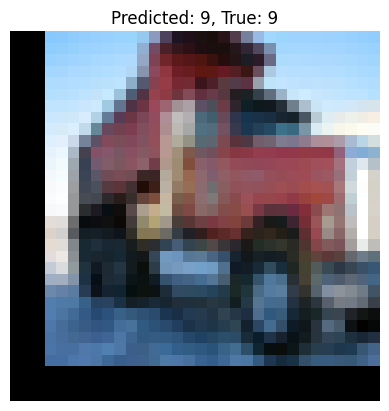

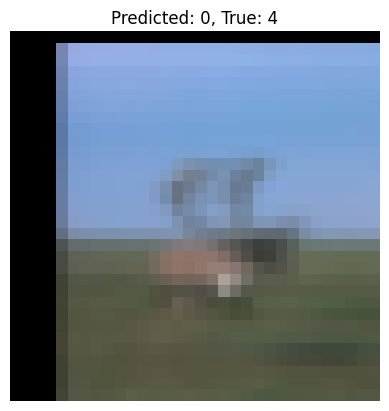

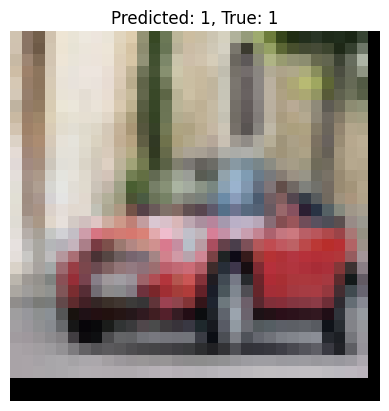

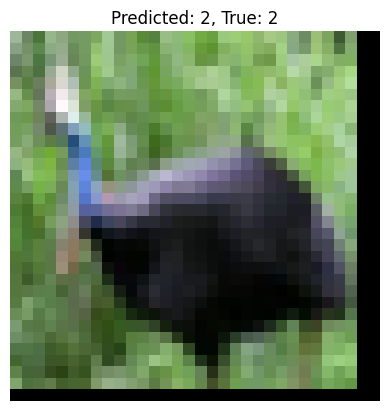

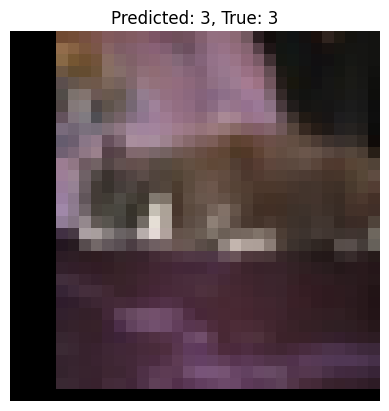

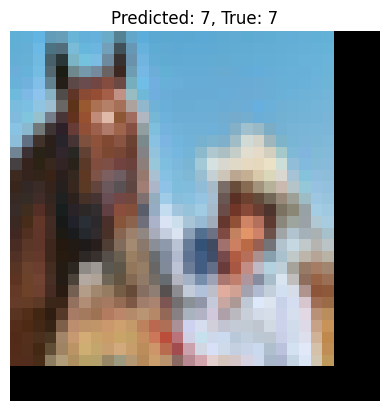

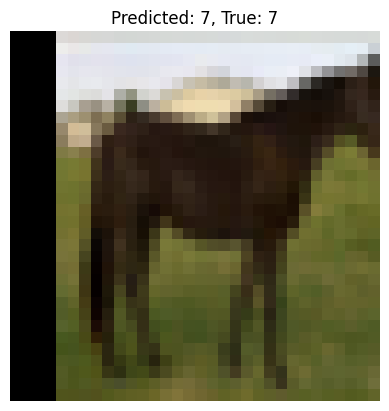

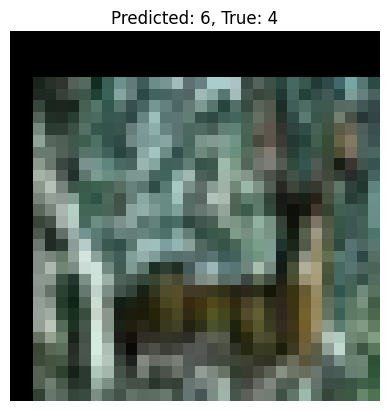

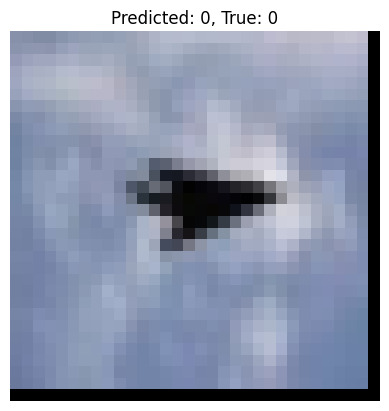

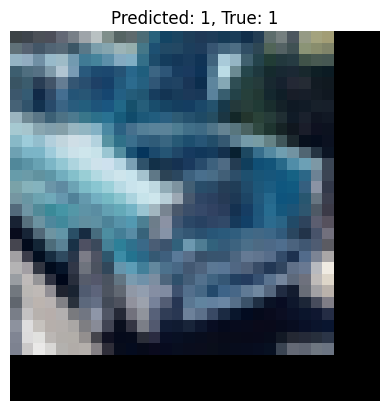

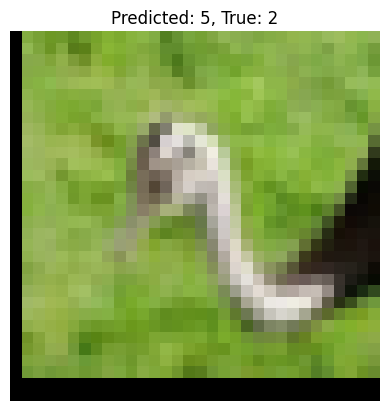

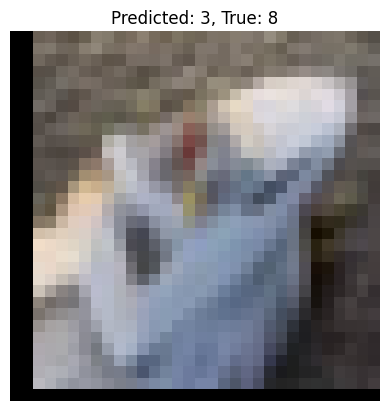

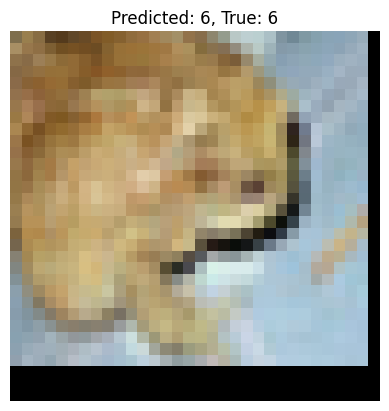

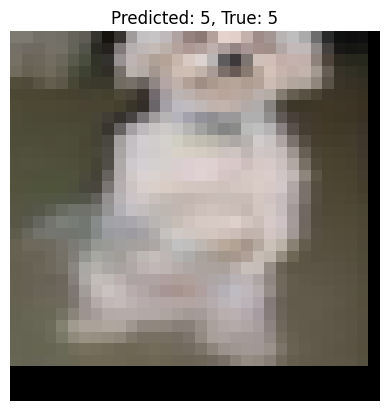

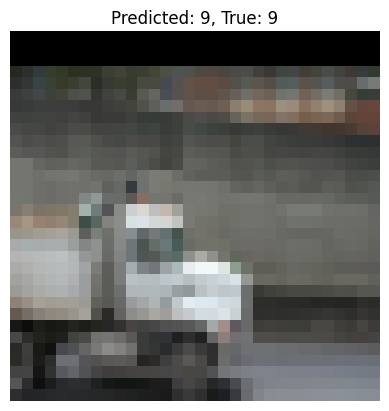

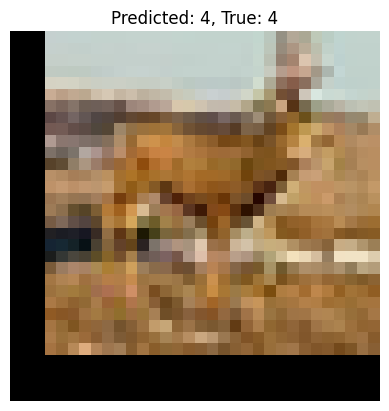

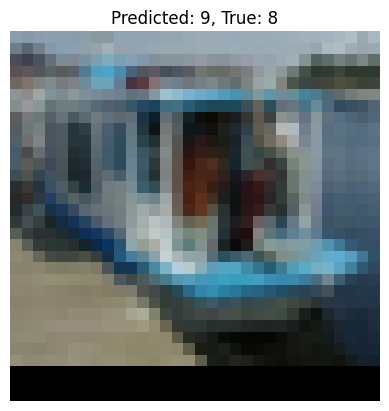

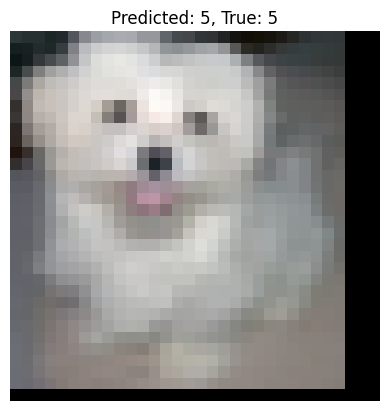

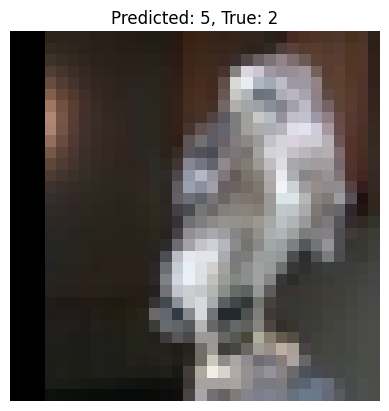

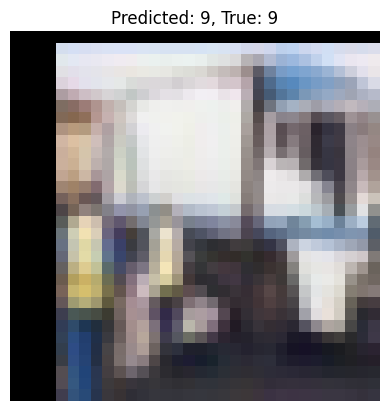

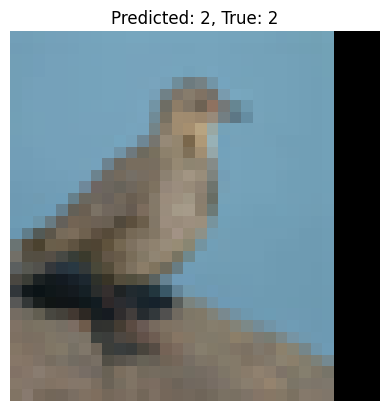

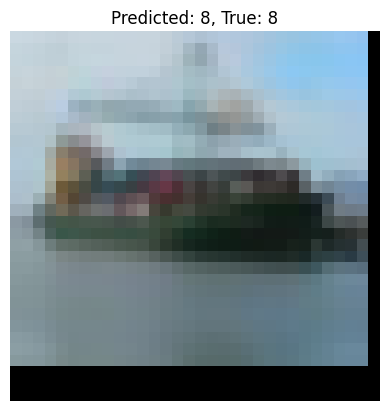

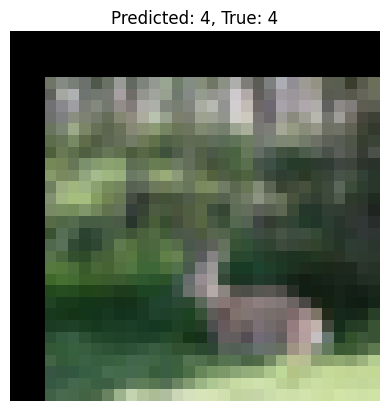

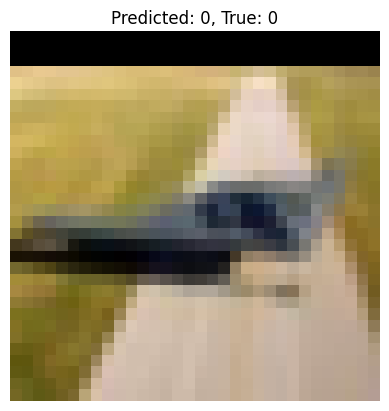

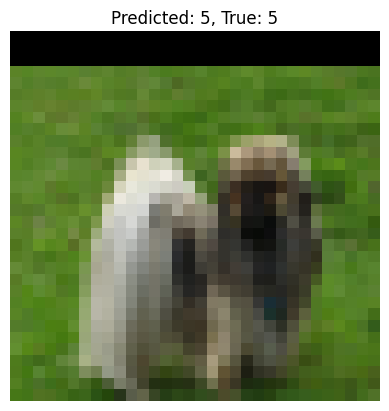

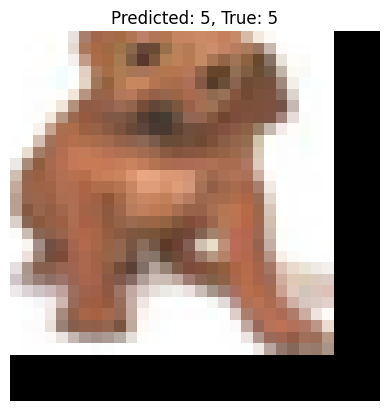

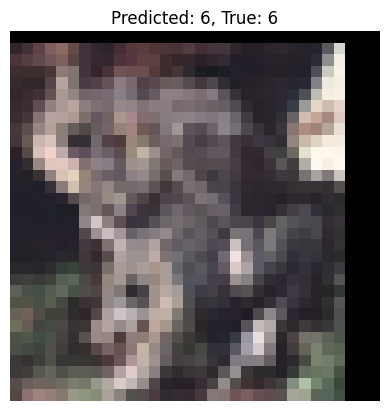

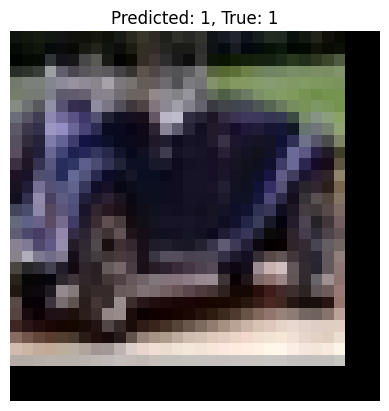

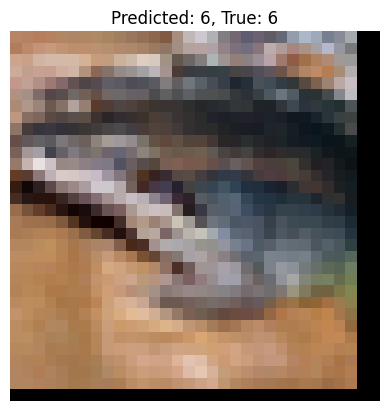

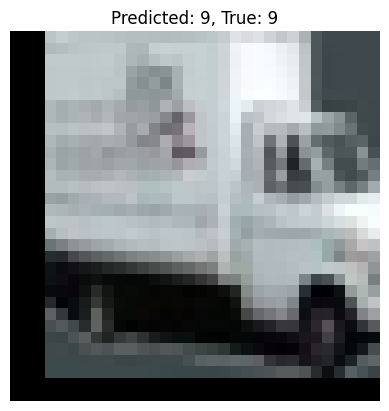

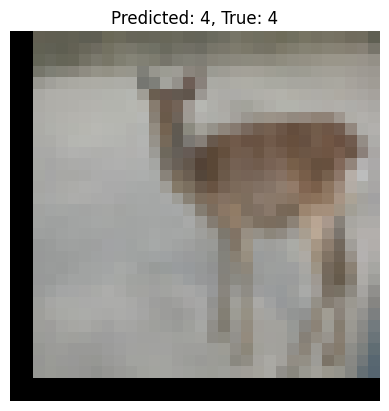

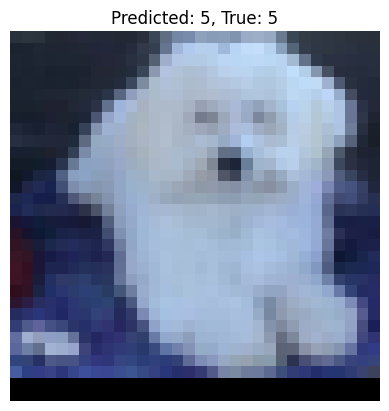

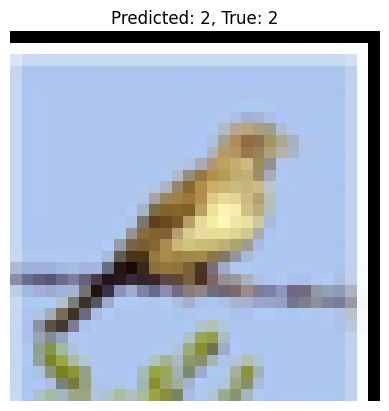

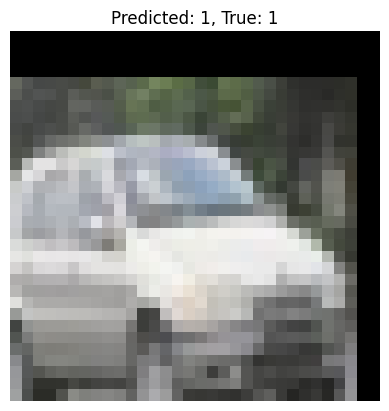

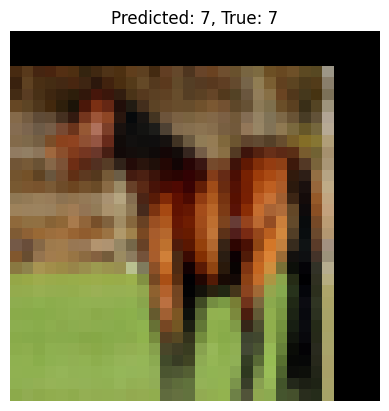

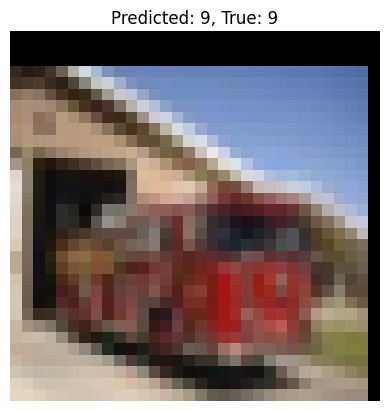

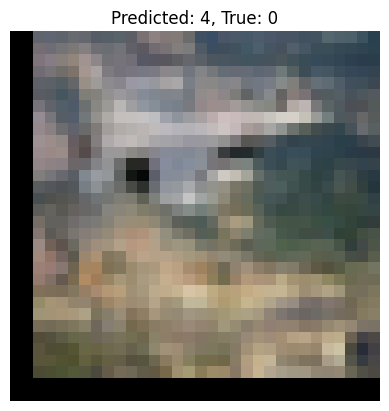

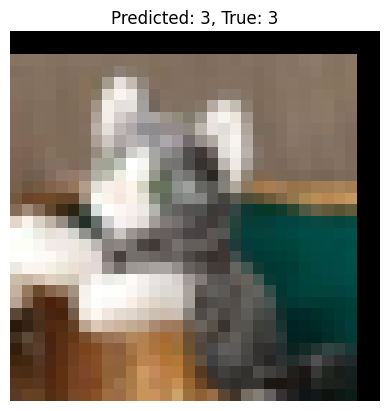

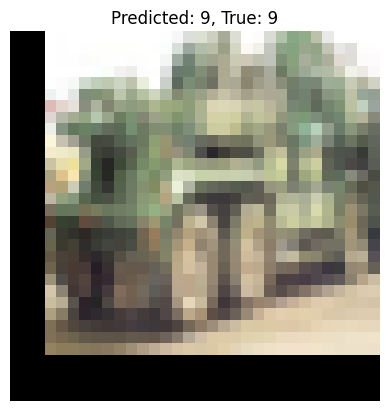

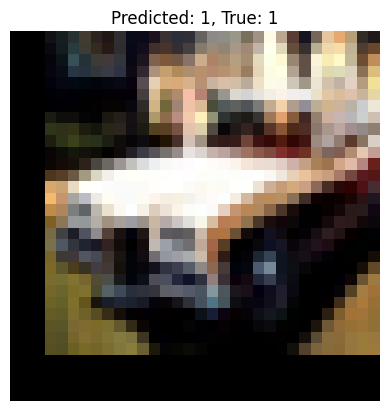

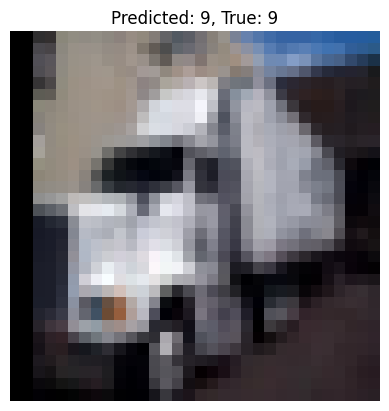

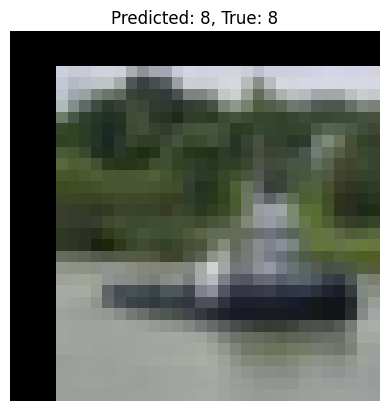

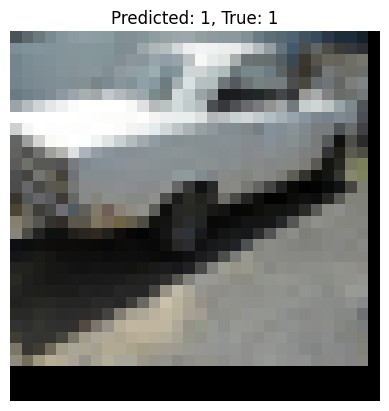

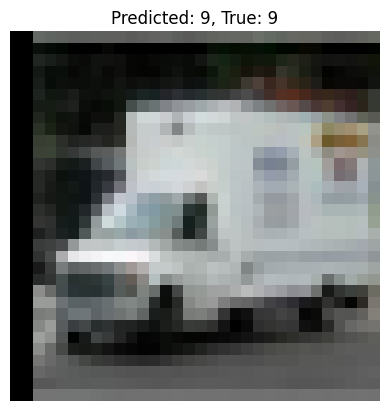

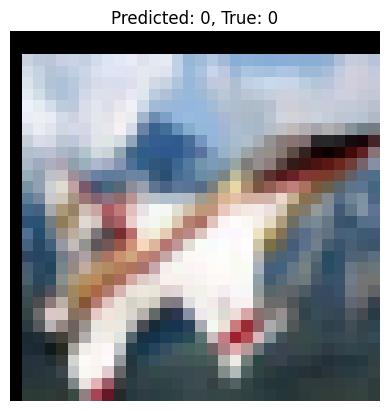

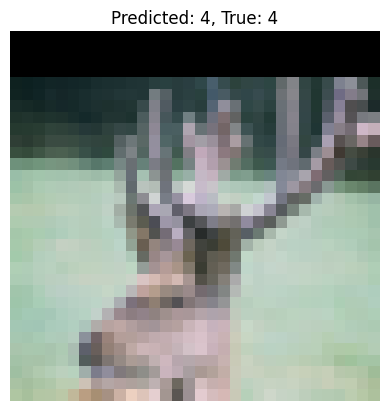

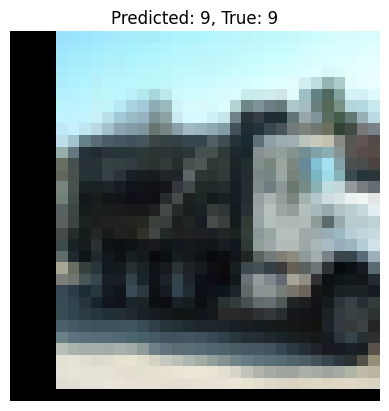

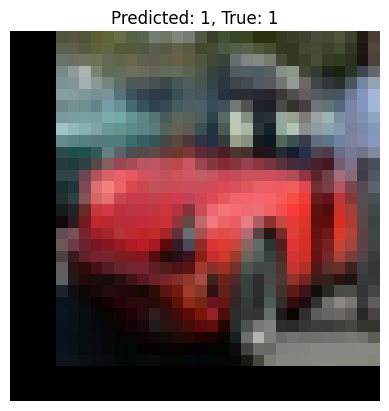

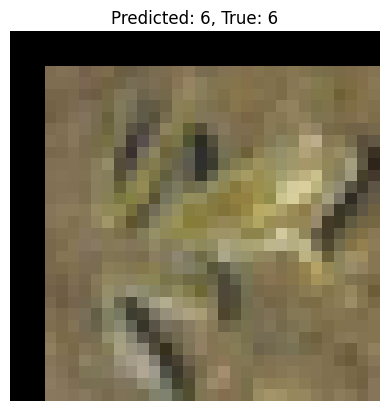

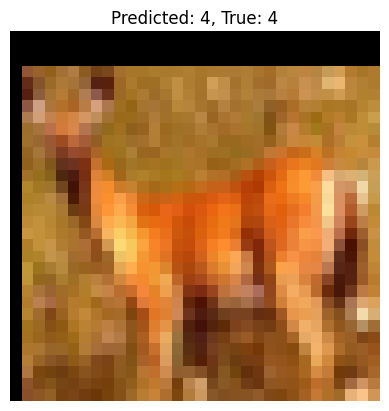

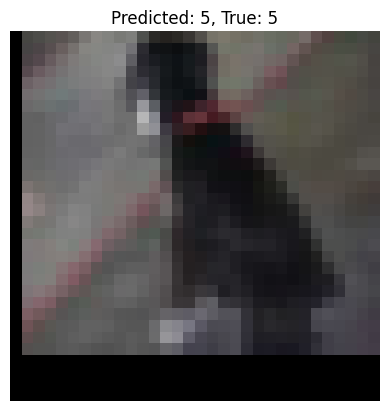

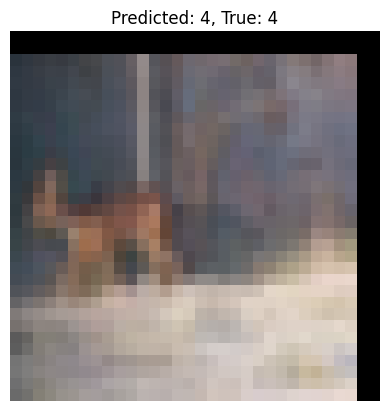

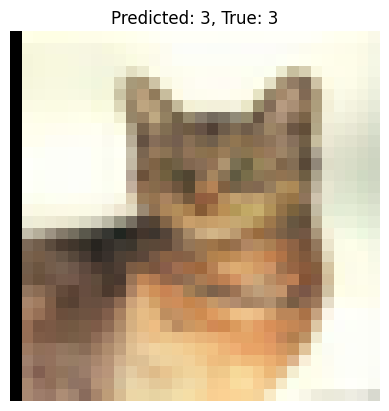

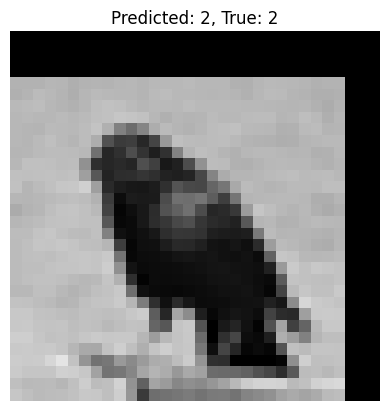

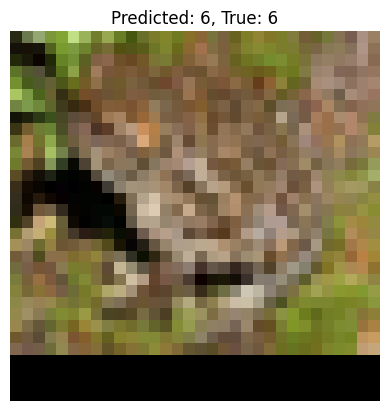

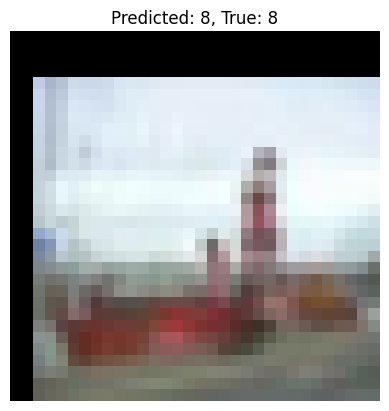

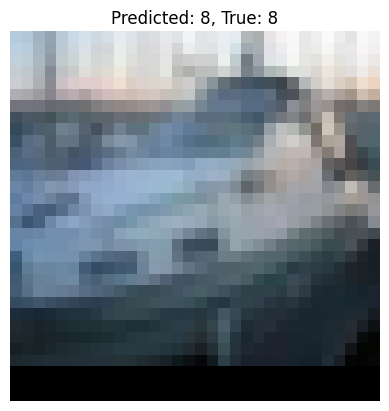

KeyboardInterrupt: 

In [28]:
correct = 0
total = 0

net.eval()

unnormalize = transforms.Normalize(
    mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], 
    std=[1 / 0.5, 1 / 0.5, 1 / 0.5]
)

with torch.no_grad() :
    for data in test_loader :
        images, labels = data
        images, labels =  images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Display a batch of images with their predictions
        for i in range(len(images)):
                # Unnormalize and convert to CPU
                img = images[i].cpu()
                img = unnormalize(img)
                img = img.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
                
                plt.imshow(img)
                plt.title(f"Predicted: {class_names[predicted[i].item()]}, True: {class_names[labels[i].item()]}")
                plt.axis('off')
                plt.show()

accuracy = 100 * correct / total
print("Accuracy = " + str(accuracy))


     

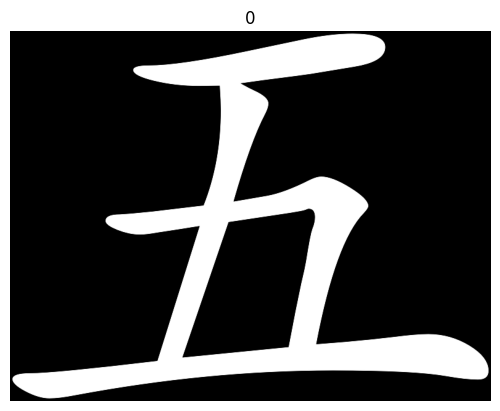

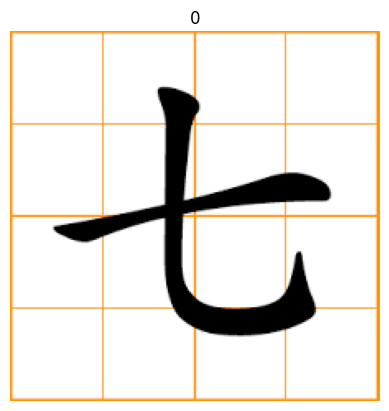

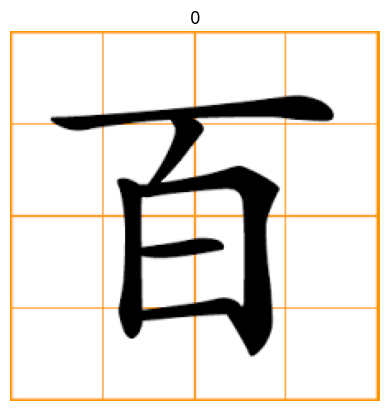

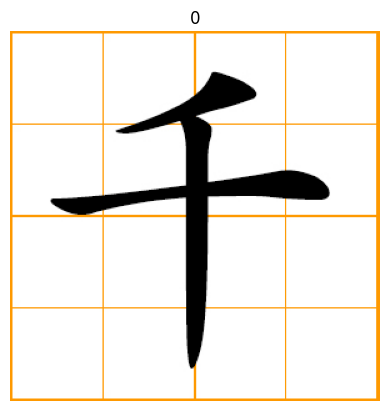

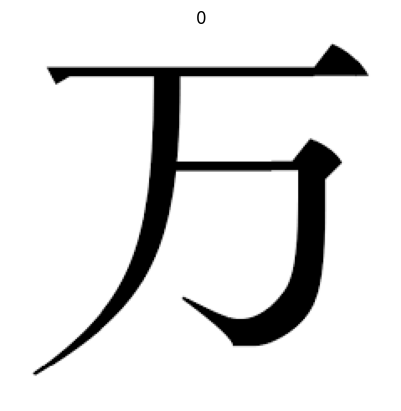

In [22]:
# TEST WITH ACTUAL IMAGES

new_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def load_images(image_path):
    original_image = Image.open(image_path).convert('RGB')
    transformed_image = new_transform(original_image).unsqueeze(0)
    return original_image, transformed_image

image_paths = ['5.png','7.png','100.png','1000.jpg','10000.png']
images = [load_images(img) for img in image_paths]

net.eval()
with torch.no_grad() :
    for original_image,image in images :
        image =  image.to(device)
        output = net(image)
        _, predicted = torch.max(output, 1)
        plt.imshow(original_image)
        plt.title(class_names[predicted.item()])
        plt.axis('off')
        plt.show()